# California Forest Fires Dataset Analysis

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Machine Learning - Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Machine Learning - Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Machine Learning - Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score
)

# Statistical tests
from scipy import stats
import math

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 2. Load and Clean Data

### __FIRE IMPACT DATA__

> 📍 Reference: https://data.ca.gov/dataset/california-fire-perimeters-all

#### Overview
The California Department of Forestry and Fire Protection's Fire and Resource Assessment Program (FRAP) maintains and distributes an historical wildland fire perimeter dataset covering public and private lands across California. This GIS data is developed in cooperation with the United States Forest Service Region 5, the Bureau of Land Management, California State Parks, National Park Service, and the United States Fish and Wildlife Service. The dataset is released annually in spring with data from the previous calendar year and covers fires dating back to 1878.

#### Data Limitations
While this dataset represents the most complete digital record of fire perimeters in California, users should exercise caution when drawing conclusions. Some fires are missing due to lost or damaged historical records, size limitations below minimum cutoffs, inadequate documentation, or incomplete database incorporation. Additional issues include duplicate fires and over-generalization, particularly with large, old fires that may show unburned "islands" within the final perimeter as burned. Users are advised to use this data carefully for statistical analysis and reporting.

#### Current Version and Updates
As of May 2025, the dataset represents version fire24_1, released in April 2025. The update added 548 fires from the 2024 fire season (distributed across various agencies: 2 from BIA, 56 from BLM, 197 from CAL FIRE, 193 from Contract Counties, 27 from LRA, 8 from NPS, 55 from USFS, and 8 from USFW), plus 6 perimeters from the 2025 fire season. Five duplicate fires were removed, and 900 perimeters received updated attribution. Quality improvements included cross-checking CAL FIRE reporting for accuracy and updating the "Powerline" cause class to "Electrical Power."

#### Data Collection Criteria
- CAL FIRE (including contract counties): Perimeters ≥10 acres in timber, ≥50 acres in brush, ≥300 acres in grass, and/or ≥3 impacted residential or commercial structures, and/or caused ≥1 fatality
- All cooperating agencies: Perimeters ≥10 acres

#### Available Layers
- California Fire Perimeters (All): Complete unfiltered collection, scale-dependent starting at country level
- Recent Large Fire Perimeters (≥5,000 acres): Fires from 2020–January 2025, color-coded by year
- California Fire Perimeters (1950+): Fires from 1950–January 2025, symbolized by decade

In [2]:
df_fire_impact = pd.read_csv("FireImpact.csv")
df_fire_impact.head()

OBJECTID    Year State Agency Unit ID  Fire Name Local Incident Number  \
0         1  2025.0    CA    CDF     LDF  PALISADES              00000738   
1         2  2025.0    CA    CDF     LAC      EATON              00009087   
2         3  2025.0    CA    CDF     ANF     HUGHES              00250270   
3         4  2025.0    CA    CCO     VNC    KENNETH              00003155   
4         5  2025.0    CA    CDF     LDF      HURST              00003294   

             Alarm Date      Containment Date  Cause  Collection Method  \
0   1/7/2025 8:00:00 AM  1/31/2025 8:00:00 AM     14                7.0   
1   1/8/2025 8:00:00 AM  1/31/2025 8:00:00 AM     14                7.0   
2  1/22/2025 8:00:00 AM  1/28/2025 8:00:00 AM     14                7.0   
3   1/9/2025 8:00:00 AM   2/4/2025 8:00:00 AM     14                2.0   
4   1/7/2025 8:00:00 AM   1/9/2025 8:00:00 AM     14                7.0   

   Management Objective  GIS Calculated Acres           Comments Complex Name  \
0                   1.0            23448.8800                NaN          NaN   
1                   1.0            14056.2600                NaN          NaN   
2                   1.0            10396.8000                NaN          NaN   
3                   1.0              998.7378  from OES Intel 24          NaN   
4                   1.0              831.3855                NaN          NaN   

                                 IRWIN ID Fire Number (historical use)  \
0  {A7EA5D21-F882-44B8-BF64-44AB11059DC1}                          NaN   
1  {72660ADC-B5EF-4D96-A33F-B4EA3740A4E3}                          NaN   
2  {994072D2-E154-434A-BB95-6F6C94C40829}                          NaN   
3  {842FB37B-7AC8-4700-BB9C-028BF753D149}                          NaN   
4  {F4E810AD-CDF3-4ED4-B63F-03D43785BA7B}                          NaN   

  Complex ID            DECADES   Shape__Area  Shape__Length  
0        NaN  2020-January 2025  1.386518e+08  140231.608232  
1        NaN  2020-January 2025  8.336393e+07  104933.207224  
2        NaN  2020-January 2025  6.216064e+07   96698.599858  
3        NaN  2020-January 2025  5.919678e+06   15602.004849  
4        NaN  2020-January 2025  4.946082e+06   16094.217073

In [3]:
# We are only interested in the alarm date and fire size from the fire impact dataset
df_fire_impact = df_fire_impact[["Alarm Date", "GIS Calculated Acres"]]

# Convert the alarm date to a datetime object
df_fire_impact["Alarm Date"] = pd.to_datetime(df_fire_impact["Alarm Date"])

print(f"Number of rows: {df_fire_impact.shape[0]}")

Number of rows: 22810


In [4]:
shape = df_fire_impact.shape
print(f"Total rows before removing NaN values: {shape[0]}")

number_of_nan_values = df_fire_impact.isna().sum()
print("NaN values:")
for column, count in number_of_nan_values.items():
  if count > 0:
    print(f"  - {column}: {count}")

Total rows before removing NaN values: 22810
NaN values:
  - Alarm Date: 5396


In [5]:
# We are removing all rows where the alarm date is not present since we cannot aggregate
# these values with the weather dataset. When training our fire size prediction model,
# we should still have enough entries in our dataset to train a good model while ignoring
# the fire damage size of fires where start date is not known
df_fire_impact = df_fire_impact[df_fire_impact["Alarm Date"].notna()]

shape = df_fire_impact.shape
print(f"\nTotal rows after removing NaN values: {shape[0]}")


Total rows after removing NaN values: 17414


In [6]:
# Print the number of duplicate rows
print(f"Number of rows before removing duplicates: {shape[0]}")

# Display the duplicate rows
display(df_fire_impact[df_fire_impact.duplicated()])

Number of rows before removing duplicates: 17414


Alarm Date  GIS Calculated Acres
4257  2014-07-20 07:00:00              0.100814
16911 1953-08-13 07:00:00              4.978838

In [7]:
# Remove the duplicate rows
df_fire_impact = df_fire_impact.drop_duplicates()

print(f"Number of rows after removing duplicates: {df_fire_impact.shape[0]}")

Number of rows after removing duplicates: 17412


### __WEATHER DATA__
> 📍 Reference: https://zenodo.org/records/14712845

#### Description:
This dataset provides a comprehensive compilation of weather observations and wildfire data in California from 1984 to 2025. Designed for researchers and practitioners, it integrates meteorological data from NOAA Climate Data Online with fire incident data from CAL FIRE. The dataset includes engineered features that enhance predictive modeling capabilities, making it suitable for wildfire prediction and analysis tasks.

#### Dataset Contents:
The dataset consists of daily records with the following fields:
  - `DATE`: The date of the observation.
  - `PRECIPITATION`: Daily precipitation in inches.
  - `MAX_TEMP`: Maximum daily temperature in degrees Fahrenheit.
  - `MIN_TEMP`: Minimum daily temperature in degrees Fahrenheit.
  - `AVG_WIND_SPEED`: Average daily wind speed in mph.
  - `FIRE_START_DAY`: A binary indicator (True/False) showing whether a wildfire started on that date.
  - `YEAR`: The year of the observation.
  - `TEMP_RANGE`: The difference between maximum and minimum temperatures, indicating daily temperature variability.
  - `WIND_TEMP_RATIO`: The ratio of average wind speed to maximum temperature, capturing wind-temperature dynamics.
  - `MONTH`: The calendar month of the observation (1-12).
  - `SEASON`: The season of the observation (Winter, Spring, Summer, Fall).
  - `LAGGED_PRECIPITATION`: Cumulative precipitation over the preceding 7 days, reflecting recent moisture conditions.
  - `LAGGED_AVG_WIND_SPEED`: Average wind speed over the preceding 7 days, indicating sustained wind patterns.
  - `DAY_OF_YEAR`: The numeric day within the year (1-365/366).

#### Potential Applications:
  - **Wildfire Prediction:** The dataset supports machine learning models for predicting fire start days, enabling proactive wildfire management strategies.
  - **Environmental Analysis:** Researchers can study the relationship between meteorological variables and wildfire dynamics.
  - **Seasonal Trends Analysis:** Temporal features allow for insights into seasonal patterns of wildfires.
  - **Model Benchmarking:** The dataset is ideal for testing and benchmarking predictive algorithms, including Random Forest, XGBoost, and other machine learning methods.
  - **Climate Impact Studies:** It can be used to analyze how climate variability influences fire risk over time.

#### Target Audience:
This dataset is suitable for data scientists, environmental researchers, wildfire management professionals, and machine learning practitioners seeking to explore the interplay between weather conditions and wildfire occurrences.

#### Usage:
The dataset is in CSV format and is ready for use in Python, R, MATLAB, or other data analysis tools. It requires no additional preprocessing and is accompanied by clear, descriptive variable names.

In [8]:
df_weather = pd.read_csv("Weather.csv")
df_weather.head()

DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  \
0  1984-01-01            0.0      79.0      51.0            4.70   
1  1984-01-02            0.0      71.0      46.0            5.59   
2  1984-01-03            0.0      70.0      47.0            5.37   
3  1984-01-04            0.0      76.0      45.0            4.70   
4  1984-01-05            0.0      74.0      49.0            5.14   

   FIRE_START_DAY  YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  \
0           False  1984        28.0         0.059494      1  Winter   
1           False  1984        25.0         0.078732      1  Winter   
2           False  1984        23.0         0.076714      1  Winter   
3           False  1984        31.0         0.061842      1  Winter   
4           False  1984        25.0         0.069459      1  Winter   

   LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  
0                   0.0                  4.700            1  
1                   0.0                  5.145            2  
2                   0.0                  5.220            3  
3                   0.0                  5.090            4  
4                   0.0                  5.100            5

In [9]:
# Convert the date to a datetime object
df_weather["DATE"] = pd.to_datetime(df_weather["DATE"])
df_weather["FIRE_START_DAY"] = df_weather["FIRE_START_DAY"].astype(int)
df_weather["SEASON"] = df_weather["SEASON"].map({
  "Winter": 1,
  "Spring": 2,
  "Summer": 3,
  "Fall": 4
})

display(df_weather.dtypes)
print(f"Number of rows: {df_weather.shape[0]}")

DATE                     datetime64[ns]
PRECIPITATION                   float64
MAX_TEMP                        float64
MIN_TEMP                        float64
AVG_WIND_SPEED                  float64
FIRE_START_DAY                    int64
YEAR                              int64
TEMP_RANGE                      float64
WIND_TEMP_RATIO                 float64
MONTH                             int64
SEASON                            int64
LAGGED_PRECIPITATION            float64
LAGGED_AVG_WIND_SPEED           float64
DAY_OF_YEAR                       int64
dtype: object

Number of rows: 14988


In [10]:
shape = df_weather.shape
print(f"Total rows before removing NaN values: {shape[0]}")

number_of_nan_values = df_weather.isna().sum()
print("NaN values:")
for column, count in number_of_nan_values.items():
  if count > 0:
    print(f"  - {column}: {count}")

Total rows before removing NaN values: 14988
NaN values:
  - PRECIPITATION: 1
  - MAX_TEMP: 1
  - MIN_TEMP: 1
  - AVG_WIND_SPEED: 12
  - TEMP_RANGE: 1
  - WIND_TEMP_RATIO: 12


In [11]:
def impute_missing_weather_data(df, column_name):
  """
  Impute missing values with the mean for the corresponding year and month
  """
  return df[column_name].fillna(
    df.groupby(["YEAR", "MONTH"])[column_name].transform("mean")
  )

# Impute missing values with the mean for the corresponding year and month
df_weather["PRECIPITATION"] = impute_missing_weather_data(df_weather, "PRECIPITATION")
df_weather["MAX_TEMP"] = impute_missing_weather_data(df_weather, "MAX_TEMP")
df_weather["MIN_TEMP"] = impute_missing_weather_data(df_weather, "MIN_TEMP")
df_weather["AVG_WIND_SPEED"] = impute_missing_weather_data(df_weather, "AVG_WIND_SPEED")
df_weather["TEMP_RANGE"] = impute_missing_weather_data(df_weather, "TEMP_RANGE")
df_weather["WIND_TEMP_RATIO"] = impute_missing_weather_data(df_weather, "WIND_TEMP_RATIO")

shape = df_weather.shape
print(f"Number of NaN values: {df_weather.isna().sum().sum()}")

Number of NaN values: 0


In [12]:
# Print the number of duplicate rows
print(f"Number of rows before removing duplicates: {shape[0]}")

# Display the duplicate rows
display(df_weather[df_weather.duplicated()])

Number of rows before removing duplicates: 14988


Empty DataFrame
Columns: [DATE, PRECIPITATION, MAX_TEMP, MIN_TEMP, AVG_WIND_SPEED, FIRE_START_DAY, YEAR, TEMP_RANGE, WIND_TEMP_RATIO, MONTH, SEASON, LAGGED_PRECIPITATION, LAGGED_AVG_WIND_SPEED, DAY_OF_YEAR]
Index: []

In [13]:
# Show the number of days when a fire started
display(df_weather["FIRE_START_DAY"].value_counts())

FIRE_START_DAY
0    10017
1     4971
Name: count, dtype: int64

In [14]:
df_fire_data = df_weather.copy()

# Convert `Alarm Date to date-only format
fire_impact_dates = pd.to_datetime(df_fire_impact["Alarm Date"]).dt.date

# Create a mapping of `Alarm Date` to total `GIS Calculated Acres` (sum for duplicate dates)
fire_damage_by_date = df_fire_impact.groupby(fire_impact_dates)["GIS Calculated Acres"].sum()

# Convert fire damage value to integer values where:
# - Class A: 0 to ¼ acre (one-fourth acre or less)
# - Class B: More than ¼ acre but less than 10 acres
# - Class C: 10 to 99 acres
# - Class D: 100 to 299 acres
# - Class E: 300 to 999 acres
# - Class F: 1,000 to 4,999 acres
# - Class G: 5,000+ acres
# REFERENCE: https://dnr.wa.gov/sites/default/files/2025-05/rp_cb_incident_response_pocket_guide.pdf
fire_damage_by_date = fire_damage_by_date.apply(
  lambda x: 0 if x <= 0.25 else 1 if x < 10 else 2 if x < 100 else 3 if x < 300 else 4 if x < 1000 else 5 if x < 5000 else 6
)

# Convert `DATE` to date-only format for matching
weather_dates = pd.to_datetime(df_fire_data["DATE"]).dt.date

# Map the fire damage sizes to matching dates
df_fire_data["FIRE_DAMAGE_SIZE"] = weather_dates.map(fire_damage_by_date).fillna(0)
df_fire_data.head()

DATE  PRECIPITATION  MAX_TEMP  MIN_TEMP  AVG_WIND_SPEED  \
0 1984-01-01            0.0      79.0      51.0            4.70   
1 1984-01-02            0.0      71.0      46.0            5.59   
2 1984-01-03            0.0      70.0      47.0            5.37   
3 1984-01-04            0.0      76.0      45.0            4.70   
4 1984-01-05            0.0      74.0      49.0            5.14   

   FIRE_START_DAY  YEAR  TEMP_RANGE  WIND_TEMP_RATIO  MONTH  SEASON  \
0               0  1984        28.0         0.059494      1       1   
1               0  1984        25.0         0.078732      1       1   
2               0  1984        23.0         0.076714      1       1   
3               0  1984        31.0         0.061842      1       1   
4               0  1984        25.0         0.069459      1       1   

   LAGGED_PRECIPITATION  LAGGED_AVG_WIND_SPEED  DAY_OF_YEAR  FIRE_DAMAGE_SIZE  
0                   0.0                  4.700            1               0.0  
1                   0.0                  5.145            2               0.0  
2                   0.0                  5.220            3               0.0  
3                   0.0                  5.090            4               0.0  
4                   0.0                  5.100            5               0.0

## 3. Exploratory Data Analysis (EDA)

### 3.1 Dataset Overview

In [15]:
# Display basic information
df_fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14988 entries, 0 to 14987
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   14988 non-null  datetime64[ns]
 1   PRECIPITATION          14988 non-null  float64       
 2   MAX_TEMP               14988 non-null  float64       
 3   MIN_TEMP               14988 non-null  float64       
 4   AVG_WIND_SPEED         14988 non-null  float64       
 5   FIRE_START_DAY         14988 non-null  int64         
 6   YEAR                   14988 non-null  int64         
 7   TEMP_RANGE             14988 non-null  float64       
 8   WIND_TEMP_RATIO        14988 non-null  float64       
 9   MONTH                  14988 non-null  int64         
 10  SEASON                 14988 non-null  int64         
 11  LAGGED_PRECIPITATION   14988 non-null  float64       
 12  LAGGED_AVG_WIND_SPEED  14988 non-null  float64       
 13  D

In [16]:
# Descriptive statistics
df_fire_data.describe().T[["count", "min", "mean", "max", "std"]]

count                  min                 mean  \
DATE                     14988  1984-01-01 00:00:00  2004-07-07 12:00:00   
PRECIPITATION          14988.0                  0.0             0.032313   
MAX_TEMP               14988.0                 50.0             70.53467   
MIN_TEMP               14988.0                 33.0            56.493646   
AVG_WIND_SPEED         14988.0                 1.79             7.433903   
FIRE_START_DAY         14988.0                  0.0             0.331665   
YEAR                   14988.0               1984.0          2004.016813   
TEMP_RANGE             14988.0                  2.0            14.041024   
WIND_TEMP_RATIO        14988.0             0.023553             0.107004   
MONTH                  14988.0                  1.0             6.518281   
SEASON                 14988.0                  1.0             2.501801   
LAGGED_PRECIPITATION   14988.0                  0.0             0.226188   
LAGGED_AVG_WIND_SPEED  14988.0             3.227143             7.434198   
DAY_OF_YEAR            14988.0                  1.0           182.992994   
FIRE_DAMAGE_SIZE       14988.0                  0.0             1.107619   

                                       max         std  
DATE                   2025-01-12 00:00:00         NaN  
PRECIPITATION                         4.53    0.179538  
MAX_TEMP                             106.0    7.263315  
MIN_TEMP                              77.0    6.767683  
AVG_WIND_SPEED                       26.17     2.12971  
FIRE_START_DAY                         1.0    0.470827  
YEAR                                2025.0   11.843342  
TEMP_RANGE                            41.0    5.995145  
WIND_TEMP_RATIO                   0.459123    0.035622  
MONTH                                 12.0    3.451037  
SEASON                                 4.0    1.115082  
LAGGED_PRECIPITATION                  8.18    0.648705  
LAGGED_AVG_WIND_SPEED            13.932857    1.387849  
DAY_OF_YEAR                          366.0  105.523627  
FIRE_DAMAGE_SIZE                       6.0    1.781173

### 3.2 Missing Values Check

In [17]:
# Check for missing values
missing_count = df_fire_data.isnull().sum().sum()
print(f"Missing values: {missing_count}")

Missing values: 0


### 3.3 Feature Distributions

In [18]:
# Create two separate datasets for fire occurrence prediction and fire damage prediction
df_fire_occurrence = df_fire_data.copy().drop(columns=["FIRE_DAMAGE_SIZE"])
display(df_fire_occurrence.describe().T[["count", "min", "mean", "max", "std"]])

count                  min                 mean  \
DATE                     14988  1984-01-01 00:00:00  2004-07-07 12:00:00   
PRECIPITATION          14988.0                  0.0             0.032313   
MAX_TEMP               14988.0                 50.0             70.53467   
MIN_TEMP               14988.0                 33.0            56.493646   
AVG_WIND_SPEED         14988.0                 1.79             7.433903   
FIRE_START_DAY         14988.0                  0.0             0.331665   
YEAR                   14988.0               1984.0          2004.016813   
TEMP_RANGE             14988.0                  2.0            14.041024   
WIND_TEMP_RATIO        14988.0             0.023553             0.107004   
MONTH                  14988.0                  1.0             6.518281   
SEASON                 14988.0                  1.0             2.501801   
LAGGED_PRECIPITATION   14988.0                  0.0             0.226188   
LAGGED_AVG_WIND_SPEED  14988.0             3.227143             7.434198   
DAY_OF_YEAR            14988.0                  1.0           182.992994   

                                       max         std  
DATE                   2025-01-12 00:00:00         NaN  
PRECIPITATION                         4.53    0.179538  
MAX_TEMP                             106.0    7.263315  
MIN_TEMP                              77.0    6.767683  
AVG_WIND_SPEED                       26.17     2.12971  
FIRE_START_DAY                         1.0    0.470827  
YEAR                                2025.0   11.843342  
TEMP_RANGE                            41.0    5.995145  
WIND_TEMP_RATIO                   0.459123    0.035622  
MONTH                                 12.0    3.451037  
SEASON                                 4.0    1.115082  
LAGGED_PRECIPITATION                  8.18    0.648705  
LAGGED_AVG_WIND_SPEED            13.932857    1.387849  
DAY_OF_YEAR                          366.0  105.523627

In [19]:
df_fire_damage = df_fire_data[df_fire_data["FIRE_START_DAY"] == 1].copy().drop(columns=["FIRE_START_DAY"])
display(df_fire_damage.describe().T[["count", "min", "mean", "max", "std"]])

count                  min  \
DATE                     4971  1984-01-27 00:00:00   
PRECIPITATION          4971.0                  0.0   
MAX_TEMP               4971.0                 56.0   
MIN_TEMP               4971.0                 35.0   
AVG_WIND_SPEED         4971.0                 2.24   
YEAR                   4971.0               1984.0   
TEMP_RANGE             4971.0                  3.0   
WIND_TEMP_RATIO        4971.0             0.025455   
MONTH                  4971.0                  1.0   
SEASON                 4971.0                  1.0   
LAGGED_PRECIPITATION   4971.0                  0.0   
LAGGED_AVG_WIND_SPEED  4971.0             3.227143   
DAY_OF_YEAR            4971.0                  1.0   
FIRE_DAMAGE_SIZE       4971.0                  0.0   

                                                mean                  max  \
DATE                   2006-08-08 08:33:01.412190720  2023-12-22 00:00:00   
PRECIPITATION                               0.002853                 3.12   
MAX_TEMP                                   74.332327                106.0   
MIN_TEMP                                   60.990143                 77.0   
AVG_WIND_SPEED                              7.529423                18.12   
YEAR                                     2006.044458               2023.0   
TEMP_RANGE                                 13.342185                 41.0   
WIND_TEMP_RATIO                             0.102288             0.270448   
MONTH                                       7.222289                 12.0   
SEASON                                      2.987528                  4.0   
LAGGED_PRECIPITATION                        0.028992                 5.32   
LAGGED_AVG_WIND_SPEED                       7.586517            12.558571   
DAY_OF_YEAR                               204.248843                366.0   
FIRE_DAMAGE_SIZE                            3.217059                  6.0   

                            std  
DATE                        NaN  
PRECIPITATION          0.051172  
MAX_TEMP               6.254286  
MIN_TEMP               5.272886  
AVG_WIND_SPEED         1.616205  
YEAR                     11.365  
TEMP_RANGE              5.70712  
WIND_TEMP_RATIO        0.025045  
MONTH                  2.231085  
SEASON                 0.802314  
LAGGED_PRECIPITATION   0.184234  
LAGGED_AVG_WIND_SPEED  1.114262  
DAY_OF_YEAR            67.81036  
FIRE_DAMAGE_SIZE       1.556889

In [20]:
# Select numeric features for visualization
features = df_fire_data.drop(
  # Remove the target features
  columns=["FIRE_START_DAY", "FIRE_DAMAGE_SIZE"]
).select_dtypes(include=[np.number]).columns

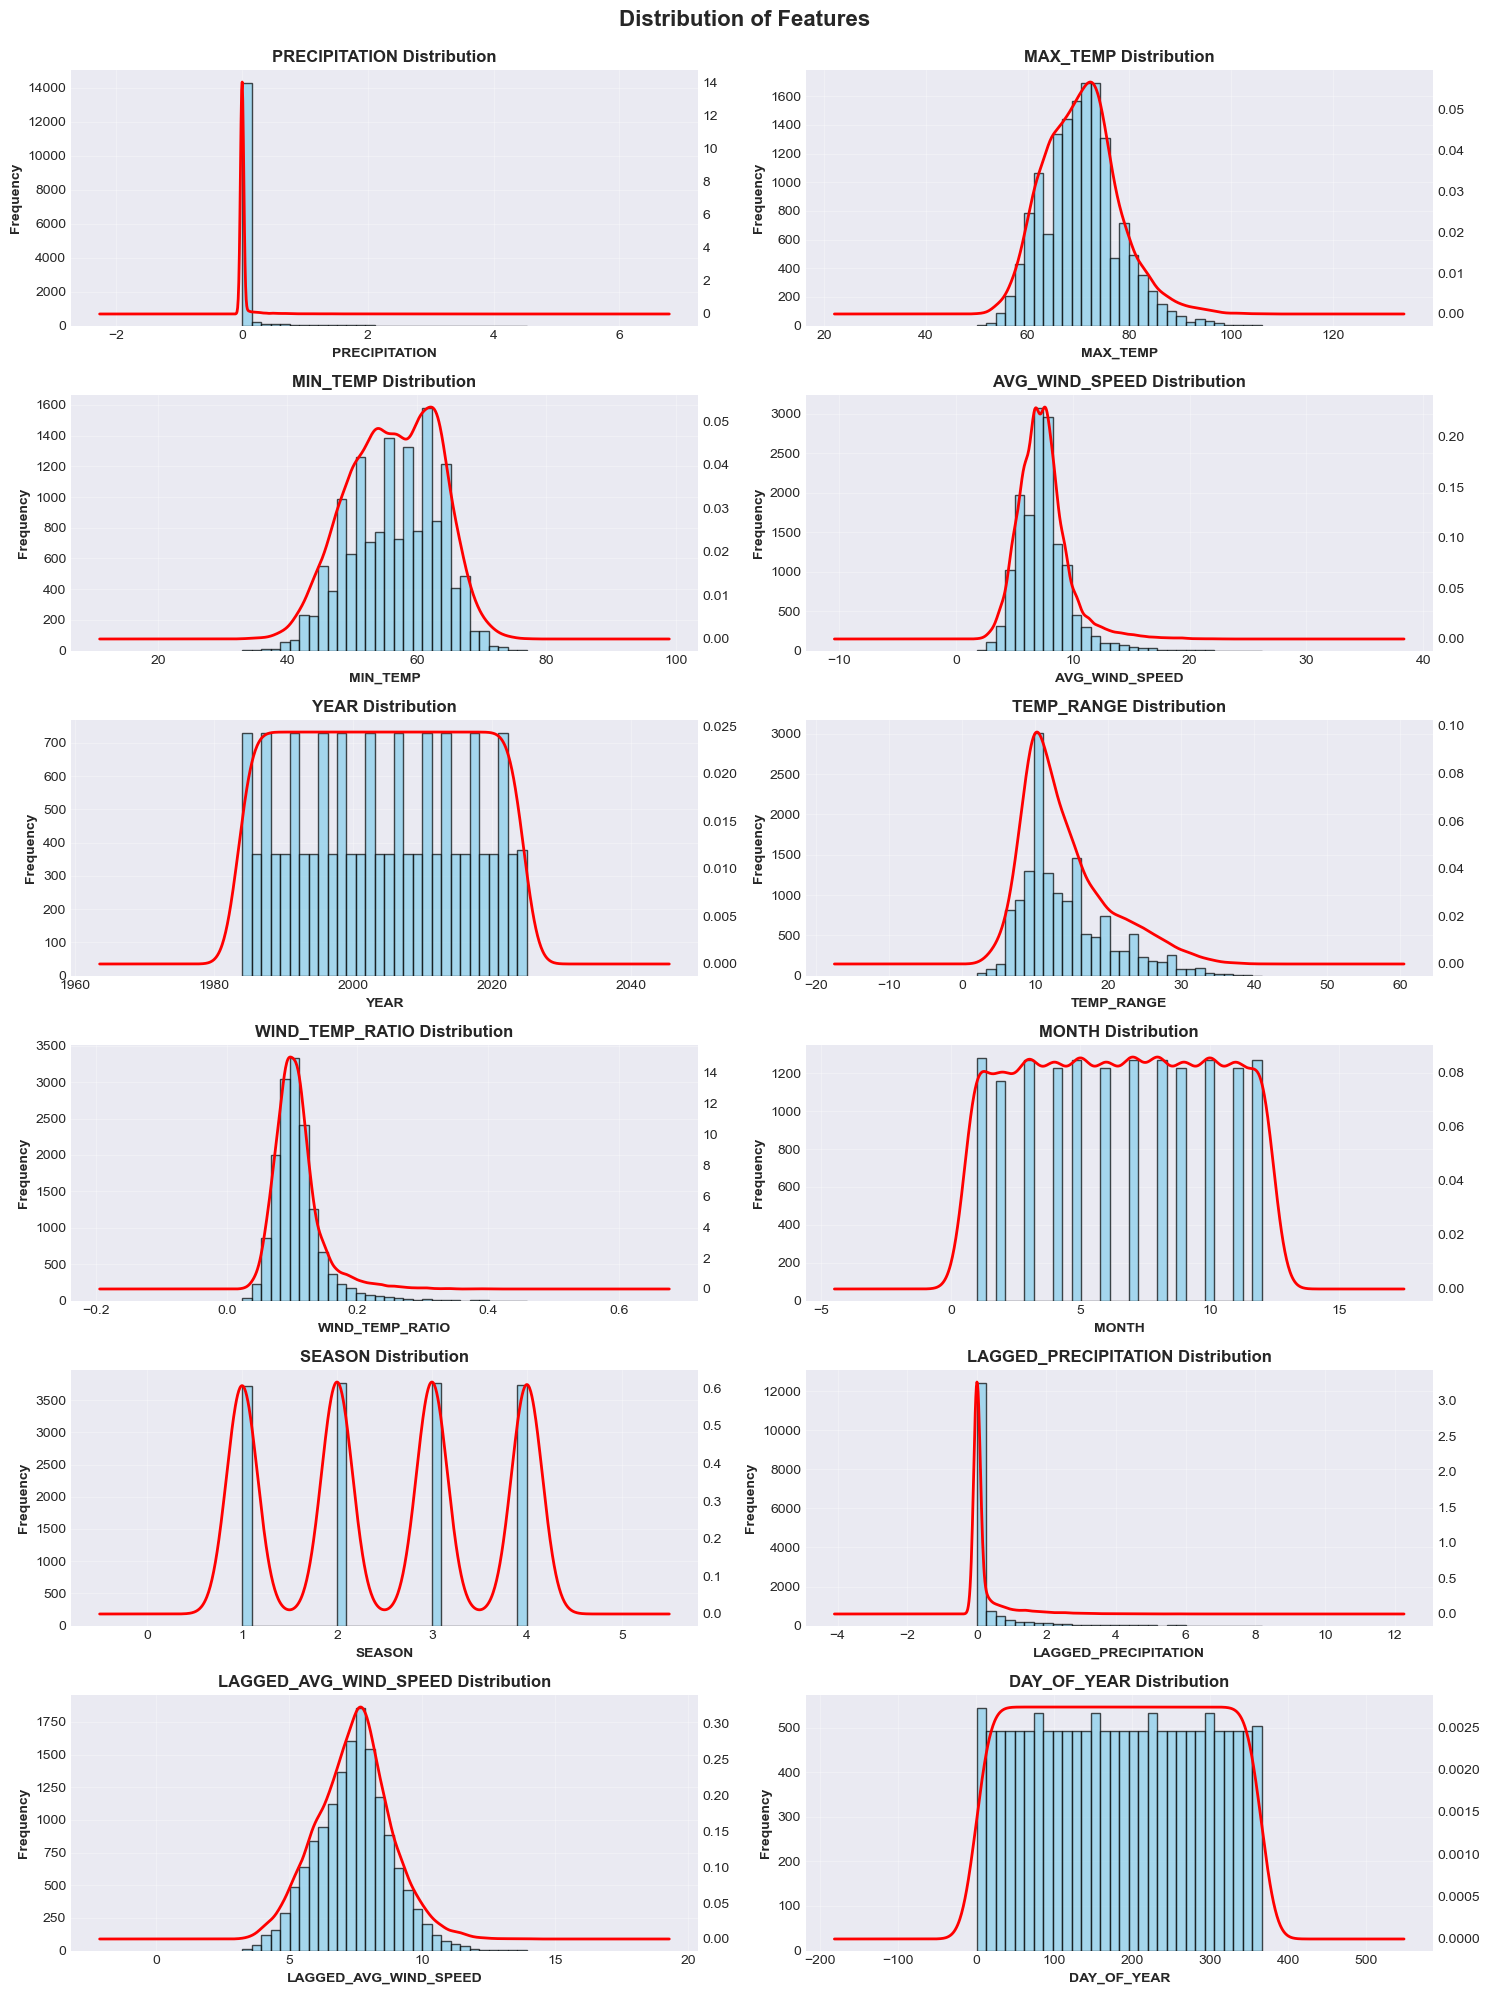

In [21]:
# Plot distributions
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
fig.suptitle('Distribution of Features', fontsize=16, fontweight='bold', y=0.995)

for idx, feature in enumerate(features):
  row = idx // 2
  col = idx % 2
  ax = axes[row, col]
  
  # Histogram with KDE
  df_fire_data[feature].hist(bins=30, alpha=0.7, color='skyblue', edgecolor='black', ax=ax)
  df_fire_data[feature].plot(kind='kde', secondary_y=True, ax=ax, color='red', linewidth=2)
  
  ax.set_xlabel(feature, fontweight='bold')
  ax.set_ylabel('Frequency', fontweight='bold')
  ax.set_title(f'{feature} Distribution', fontweight='bold')
  ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 Correlation Analysis

In [22]:
def get_correlation_strength(df, target_feature, columns):
  return df[columns].corrwith(df[target_feature]).sort_values(ascending=False)

def print_correlation_analysis(correlation_df, target_feature):
  print(f"Correlation with {target_feature}:")
  for feature, corr in correlation_df.items():
    correlation_strength = 'STRONG' if abs(corr) > 0.5 else 'MEDIUM' if abs(corr) > 0.3 else 'WEAK'
    print(f"{feature:45s}: {corr:.3f}  ({correlation_strength})")

def visualize_correlation_analysis(correlation_df, target_feature):
  # Visualize correlations with target
  plt.figure(figsize=(10, 6))
  colors = ['red' if x > 0 else 'blue' for x in correlation_df.values]
  plt.barh(range(len(correlation_df)), correlation_df.values, color=colors, alpha=0.7)
  plt.yticks(range(len(correlation_df)), correlation_df.index)
  plt.title(f'Feature Correlations with {target_feature}', fontweight='bold', fontsize=14)
  plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
  plt.grid(axis='x', alpha=0.3)

  plt.show()

#### Correlation Analysis for Fire Start

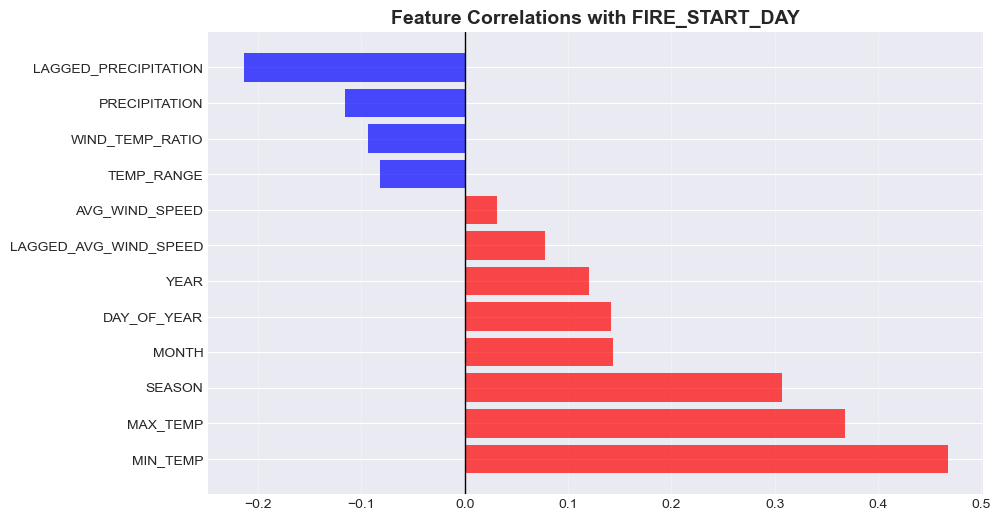

Correlation with FIRE_START_DAY:
MIN_TEMP                                     : 0.468  (MEDIUM)
MAX_TEMP                                     : 0.368  (MEDIUM)
SEASON                                       : 0.307  (MEDIUM)
MONTH                                        : 0.144  (WEAK)
DAY_OF_YEAR                                  : 0.142  (WEAK)
YEAR                                         : 0.121  (WEAK)
LAGGED_AVG_WIND_SPEED                        : 0.077  (WEAK)
AVG_WIND_SPEED                               : 0.032  (WEAK)
TEMP_RANGE                                   : -0.082  (WEAK)
WIND_TEMP_RATIO                              : -0.093  (WEAK)
PRECIPITATION                                : -0.116  (WEAK)
LAGGED_PRECIPITATION                         : -0.214  (WEAK)


In [23]:
df_fire_occurrence_correlation = get_correlation_strength(df_fire_occurrence, 'FIRE_START_DAY', features)
visualize_correlation_analysis(df_fire_occurrence_correlation, 'FIRE_START_DAY')
print_correlation_analysis(df_fire_occurrence_correlation, 'FIRE_START_DAY')

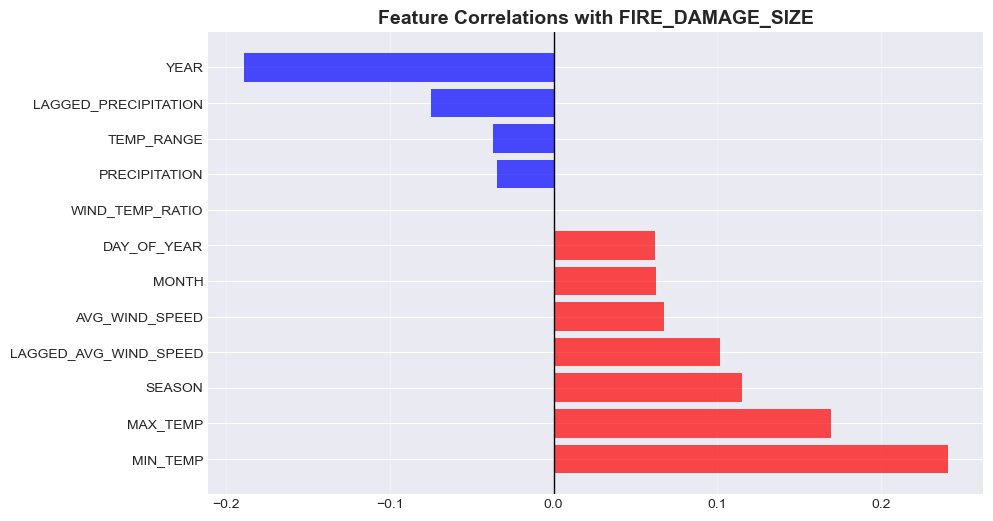

Correlation with FIRE_DAMAGE_SIZE:
MIN_TEMP                                     : 0.241  (WEAK)
MAX_TEMP                                     : 0.169  (WEAK)
SEASON                                       : 0.115  (WEAK)
LAGGED_AVG_WIND_SPEED                        : 0.102  (WEAK)
AVG_WIND_SPEED                               : 0.068  (WEAK)
MONTH                                        : 0.063  (WEAK)
DAY_OF_YEAR                                  : 0.062  (WEAK)
WIND_TEMP_RATIO                              : 0.000  (WEAK)
PRECIPITATION                                : -0.034  (WEAK)
TEMP_RANGE                                   : -0.037  (WEAK)
LAGGED_PRECIPITATION                         : -0.075  (WEAK)
YEAR                                         : -0.189  (WEAK)


In [24]:
df_fire_damage_correlation = get_correlation_strength(df_fire_damage, 'FIRE_DAMAGE_SIZE', features)
visualize_correlation_analysis(df_fire_damage_correlation, 'FIRE_DAMAGE_SIZE')
print_correlation_analysis(df_fire_damage_correlation, 'FIRE_DAMAGE_SIZE')

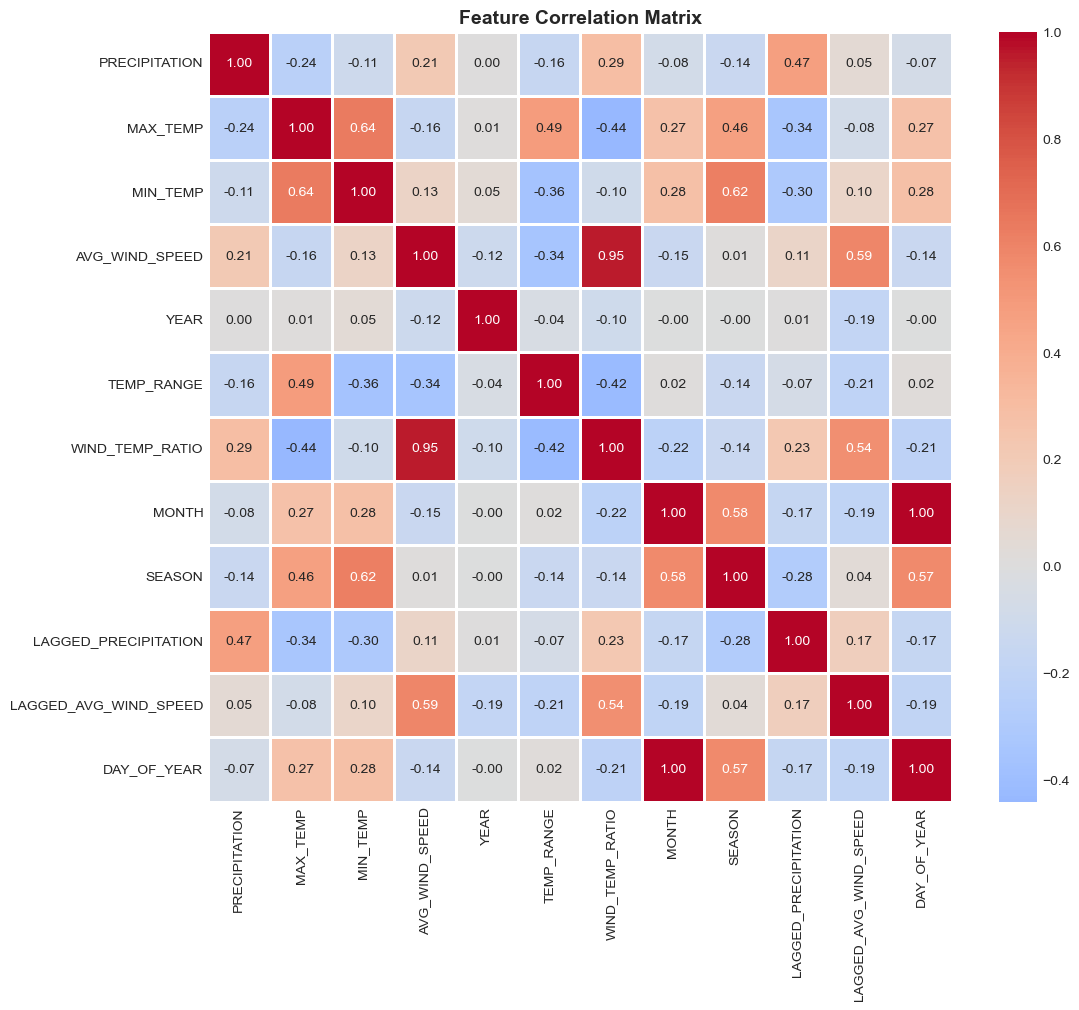

Highly correlated pairs (> 0.5):
  - MAX_TEMP & MIN_TEMP -> 0.637
  - MIN_TEMP & SEASON -> 0.620
  - AVG_WIND_SPEED & WIND_TEMP_RATIO -> 0.951
  - AVG_WIND_SPEED & LAGGED_AVG_WIND_SPEED -> 0.595
  - WIND_TEMP_RATIO & LAGGED_AVG_WIND_SPEED -> 0.544
  - MONTH & SEASON -> 0.575
  - MONTH & DAY_OF_YEAR -> 0.997
  - SEASON & DAY_OF_YEAR -> 0.573


In [25]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_fire_data[features].corr()
sns.heatmap(
  corr_matrix,
  annot=True,
  fmt='.2f',
  cmap='coolwarm',
  center=0,
  linewidths=1,
)
plt.title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
plt.show()

print("Highly correlated pairs (> 0.5):")
for i in range(len(corr_matrix.columns)):
  for j in range(i+1, len(corr_matrix.columns)):
    if abs(corr_matrix.iloc[i, j]) > 0.5:
      print(f"  - {corr_matrix.columns[i]} & {corr_matrix.columns[j]} -> {corr_matrix.iloc[i, j]:.3f}")

### 3.5 Distribution by Fire Class

In [26]:
def show_box_plots(df, target_feature, columns):
  fig, axes = plt.subplots(6, 2, figsize=(15, 20))
  fig.suptitle(f'Feature Distributions by {target_feature}', fontsize=16, fontweight='bold', y=0.995)
  
  for idx, feature in enumerate(columns):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Box plot
    df.boxplot(column=feature, by=target_feature, ax=ax)
    ax.set_xlabel(target_feature, fontweight='bold')
    ax.set_ylabel(feature, fontweight='bold')
    ax.set_title(f'{feature} by {target_feature}', fontweight='bold')
    ax.get_figure().suptitle('')  # Remove automatic title
    
  plt.tight_layout()
  plt.show()

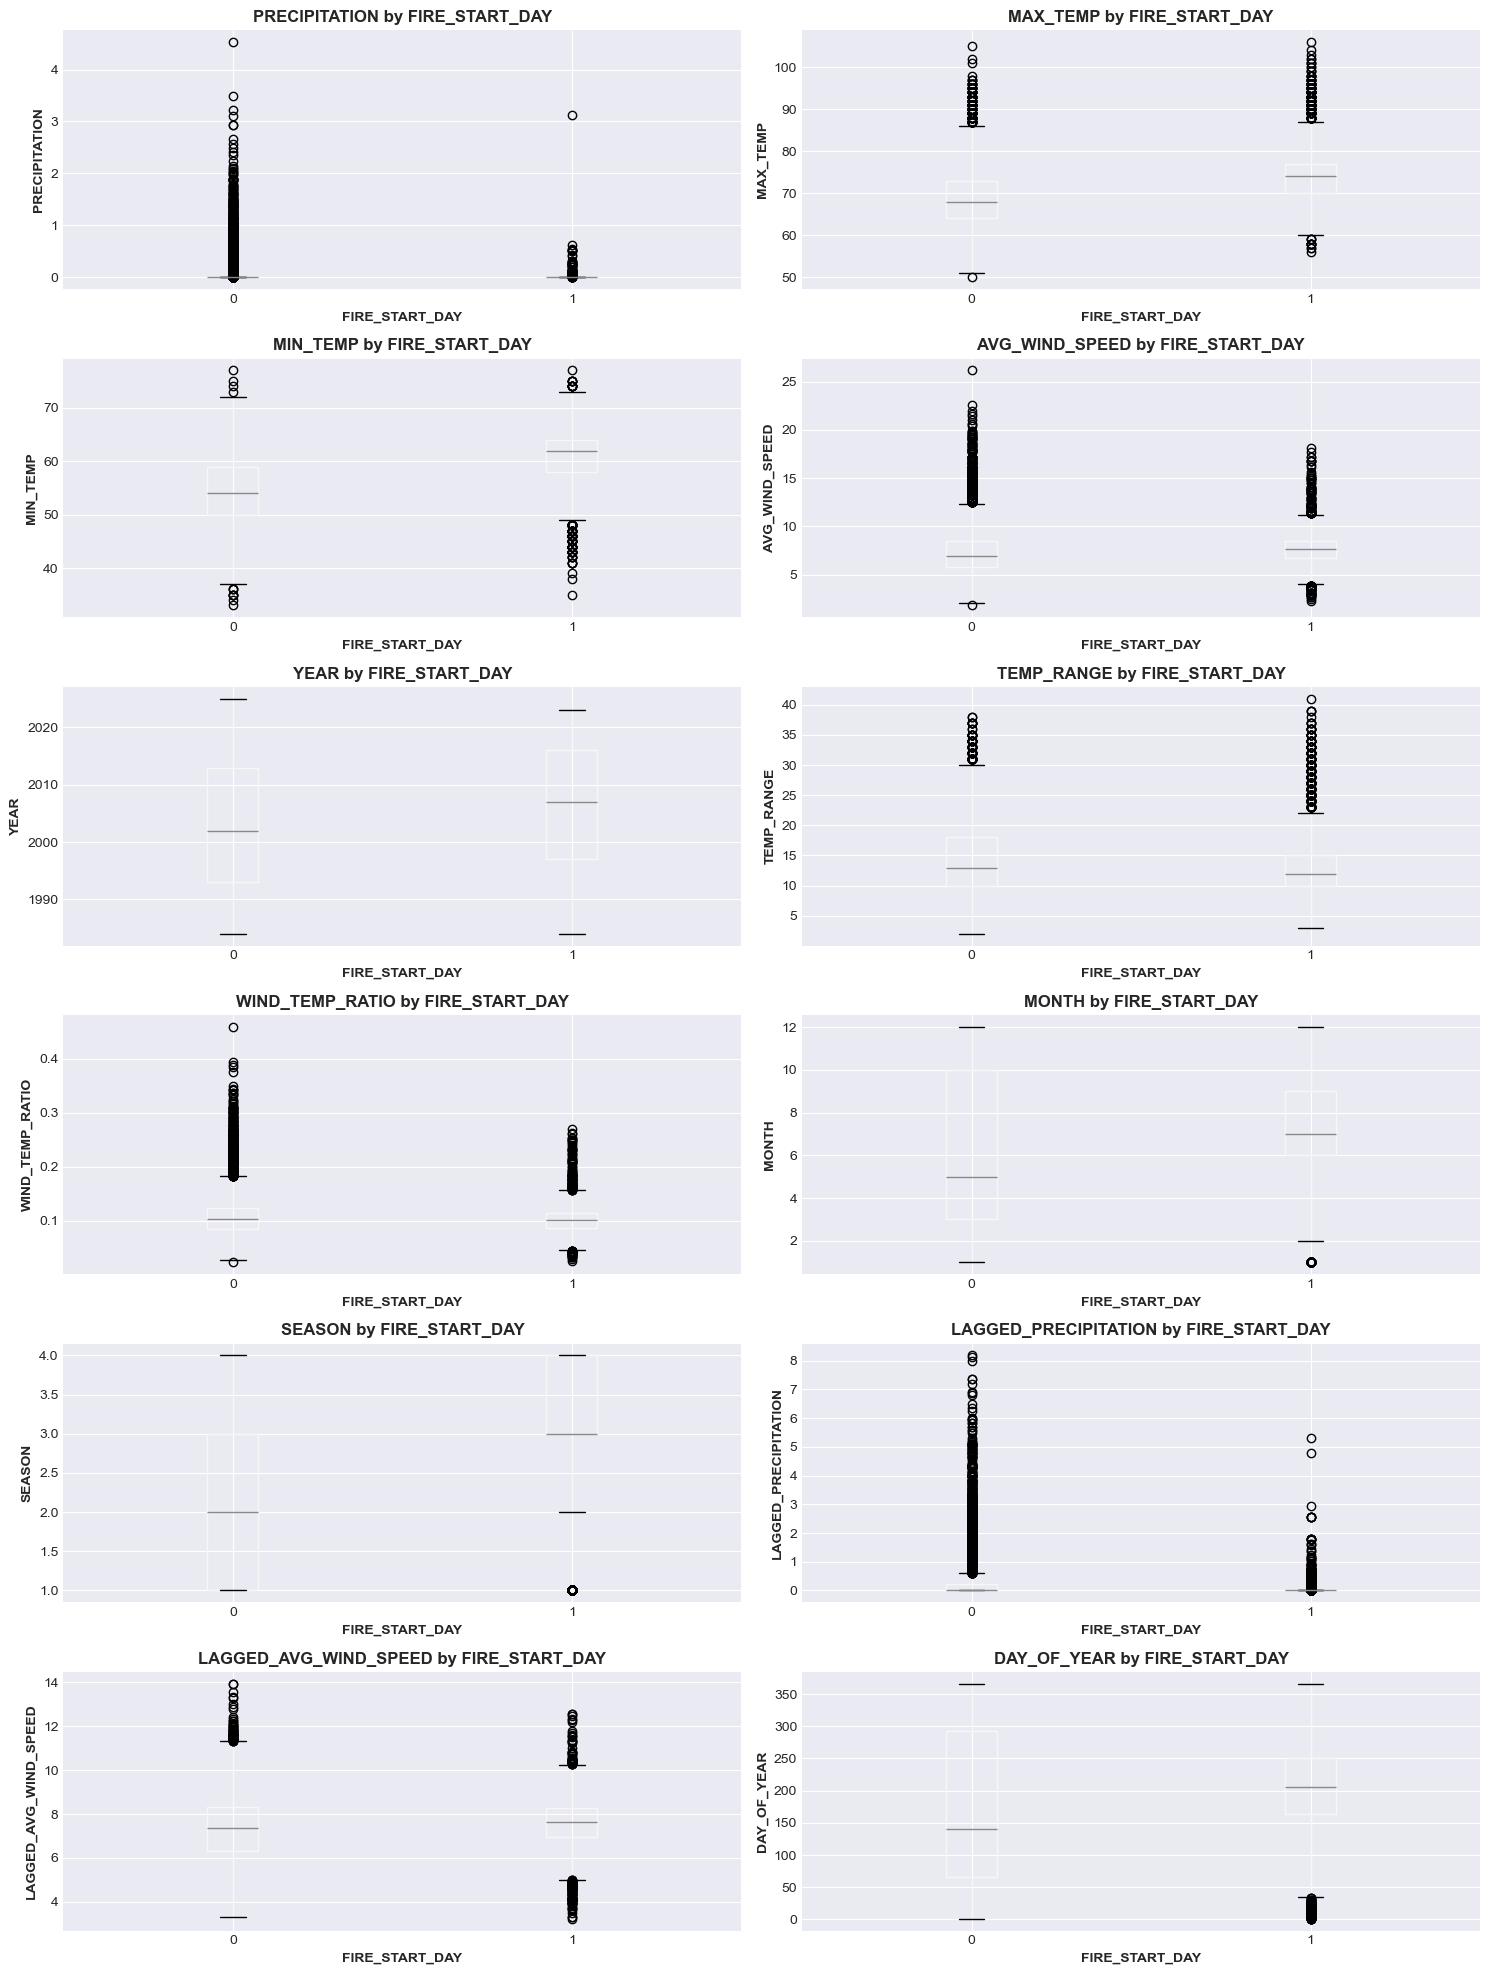

In [27]:
show_box_plots(df_fire_occurrence, "FIRE_START_DAY", features)

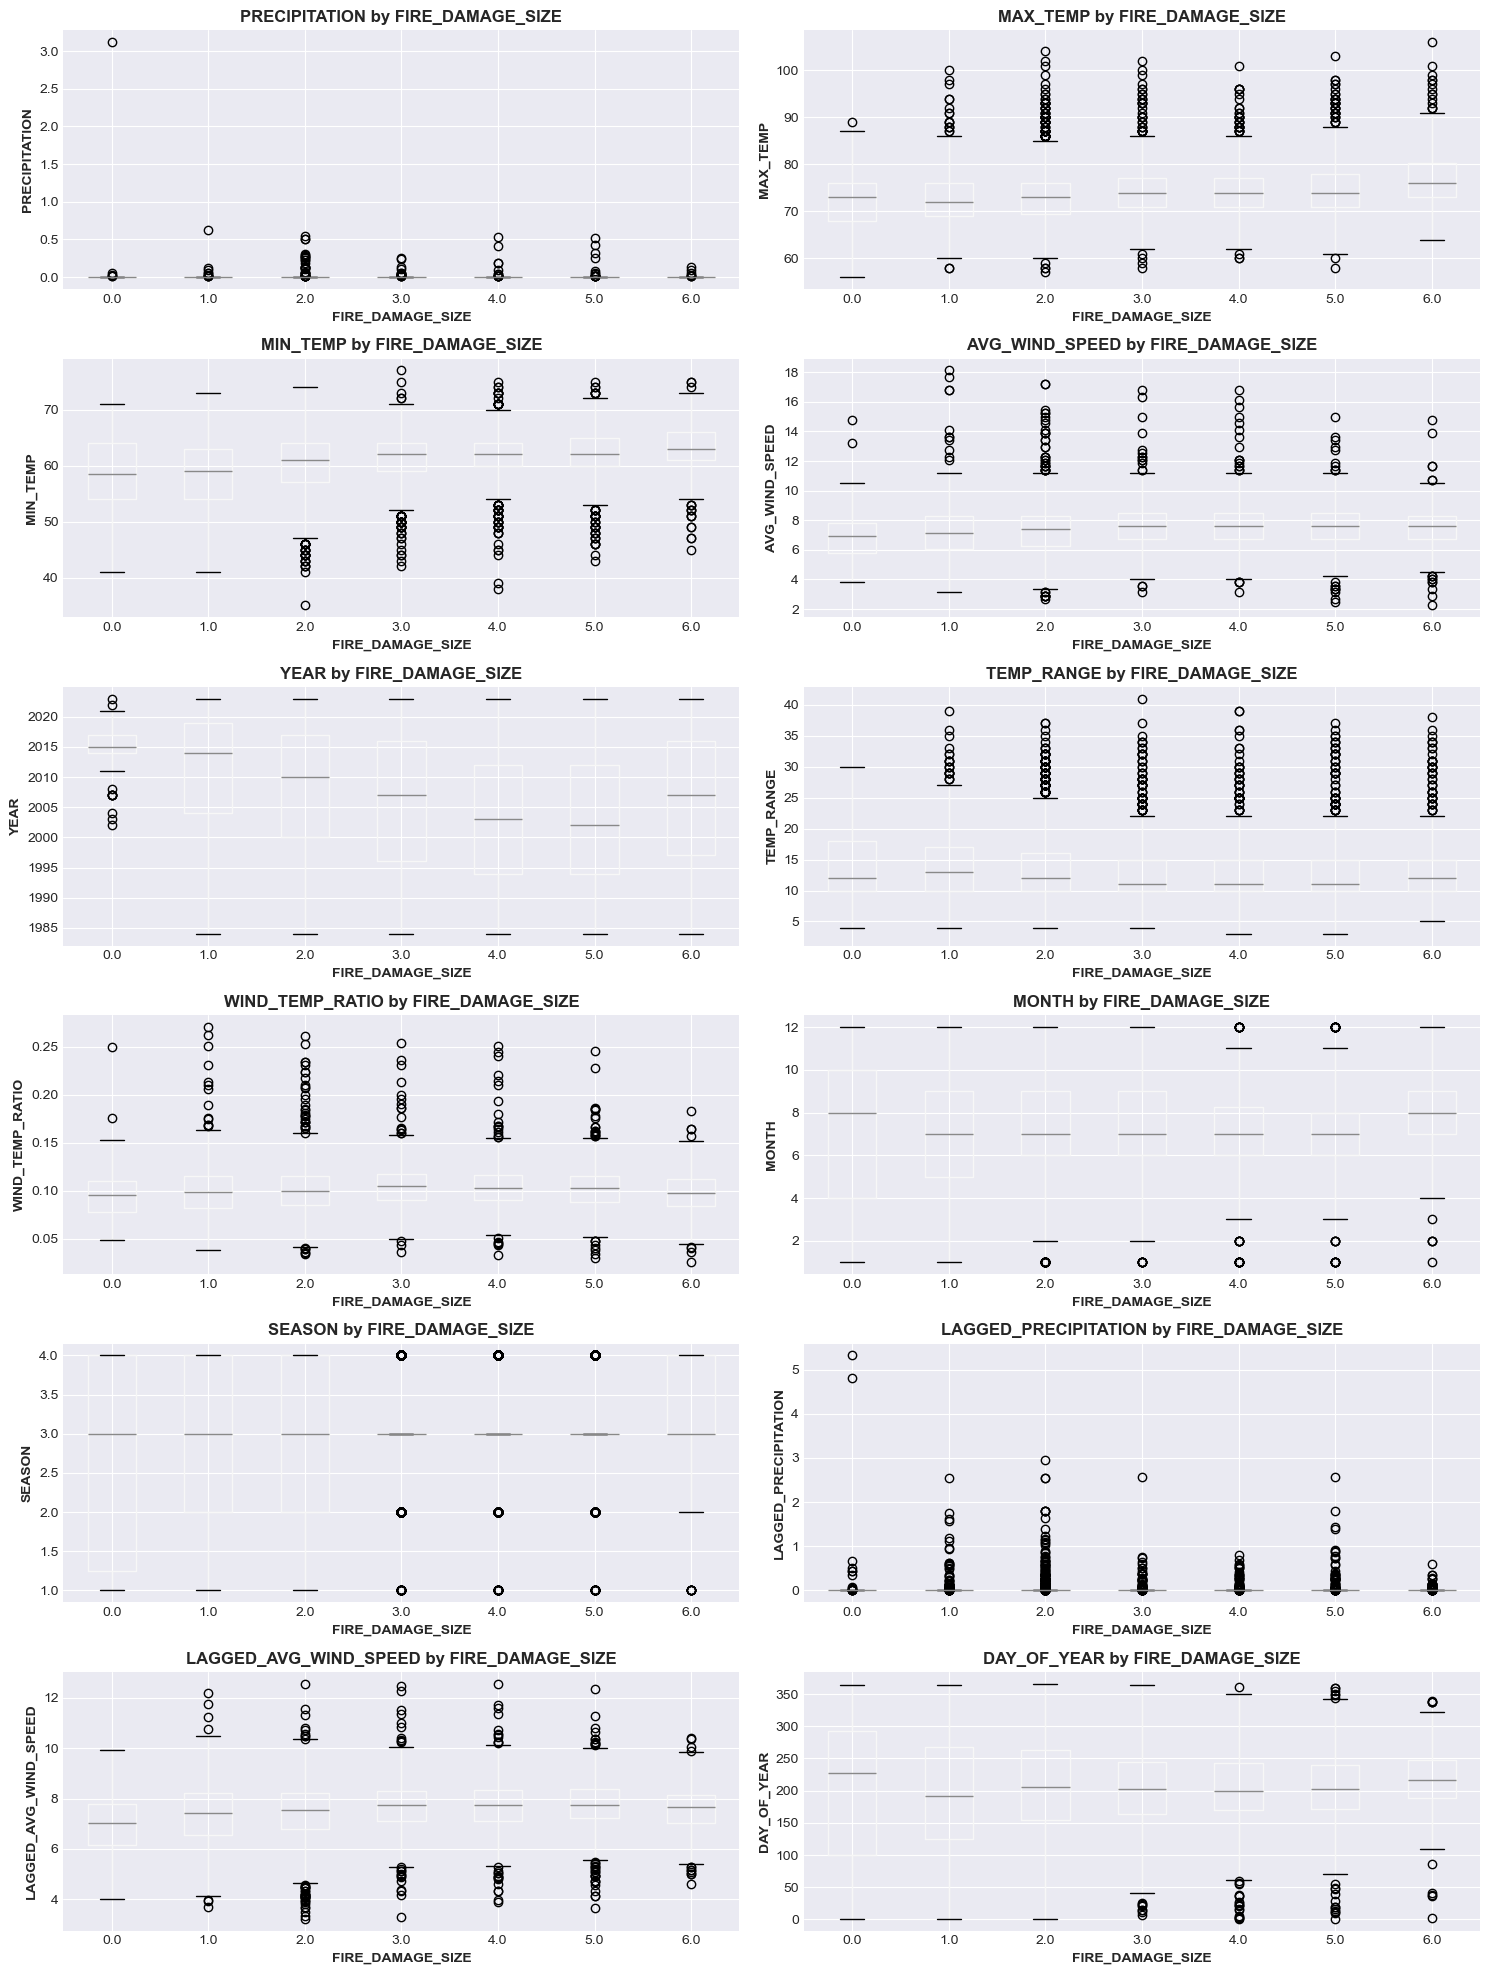

In [28]:
show_box_plots(df_fire_damage, "FIRE_DAMAGE_SIZE", features)

In [29]:
# Statistical comparison between fire and not fire
fire_means = df_fire_occurrence[df_fire_occurrence['FIRE_START_DAY'] == 1][features].mean()
no_fire_means = df_fire_occurrence[df_fire_occurrence['FIRE_START_DAY'] == 0][features].mean()
difference = fire_means - no_fire_means

comparison_df = pd.DataFrame({
    'Fire': fire_means,
    'Not Fire': no_fire_means,
    'Difference': difference,
    'Pct_Change': (difference / no_fire_means * 100)
}).round(2)

comparison_df.sort_values('Pct_Change', ascending=False)

Fire  Not Fire  Difference  Pct_Change
SEASON                    2.99      2.26        0.73       32.15
DAY_OF_YEAR             204.25    172.44       31.80       18.44
MONTH                     7.22      6.17        1.05       17.08
MIN_TEMP                 60.99     54.26        6.73       12.40
MAX_TEMP                 74.33     68.65        5.68        8.28
LAGGED_AVG_WIND_SPEED     7.59      7.36        0.23        3.10
AVG_WIND_SPEED            7.53      7.39        0.14        1.93
YEAR                   2006.04   2003.01        3.03        0.15
WIND_TEMP_RATIO           0.10      0.11       -0.01       -6.45
TEMP_RANGE               13.34     14.39       -1.05       -7.27
LAGGED_PRECIPITATION      0.03      0.32       -0.30      -91.05
PRECIPITATION             0.00      0.05       -0.04      -93.92

In [30]:
# Calculate the mean for each category
category_fire_means = []
for i in range(7):
  category_fire_means.append(df_fire_damage[df_fire_damage['FIRE_DAMAGE_SIZE'] == i][features].mean())

comparison_df = pd.DataFrame({})
for i in range(len(category_fire_means)):
  comparison_df[f"Category {i}"] = category_fire_means[i]

comparison_df

Category 0   Category 1   Category 2   Category 3  \
PRECIPITATION             0.039512     0.002272     0.003258     0.001354   
MAX_TEMP                 72.682927    72.951002    73.531997    74.203088   
MIN_TEMP                 58.414634    58.563474    60.086619    61.203088   
AVG_WIND_SPEED            7.045976     7.302895     7.364919     7.732221   
YEAR                   2014.634146  2010.409800  2007.939884  2005.490499   
TEMP_RANGE               14.268293    14.387528    13.445378    13.000000   
WIND_TEMP_RATIO           0.098524     0.101304     0.101149     0.105174   
MONTH                     6.951220     6.799555     7.258565     7.144893   
SEASON                    2.707317     2.761693     2.946994     3.014252   
LAGGED_PRECIPITATION      0.155854     0.048085     0.038649     0.016176   
LAGGED_AVG_WIND_SPEED     7.034582     7.405807     7.451343     7.706697   
DAY_OF_YEAR             197.341463   191.752784   205.213316   201.706651   

                        Category 4   Category 5   Category 6  
PRECIPITATION             0.001896     0.002462     0.000766  
MAX_TEMP                 74.583333    75.134801    76.975806  
MIN_TEMP                 61.712560    62.020633    63.352823  
AVG_WIND_SPEED            7.703841     7.689904     7.456835  
YEAR                   2002.934783  2002.497937  2006.090726  
TEMP_RANGE               12.870773    13.114168    13.622984  
WIND_TEMP_RATIO           0.104080     0.103406     0.097823  
MONTH                     7.202899     7.229711     7.689516  
SEASON                    3.048309     3.008253     3.187500  
LAGGED_PRECIPITATION      0.013563     0.028542     0.008790  
LAGGED_AVG_WIND_SPEED     7.719779     7.743118     7.606941  
DAY_OF_YEAR             203.712560   204.552957   218.459677

### 3.6 Statistical Tests

In [31]:
# T-tests for each feature
print(f"{'Feature':<25} {'t-statistic':<25} {'p-value':<25} {'Significant?'}")
print("-"*90)

fire_data = df_fire_occurrence[df_fire_occurrence['FIRE_START_DAY'] == 1]
no_fire_data = df_fire_occurrence[df_fire_occurrence['FIRE_START_DAY'] == 0]

for feature in features:
  t_stat, p_value = stats.ttest_ind(fire_data[feature], no_fire_data[feature])
  significant = "YES" if p_value < 0.05 else "NO"
  print(f"{feature:<25} {t_stat:<25.3f} {p_value:<25.6f} {significant}")

Feature                   t-statistic               p-value                   Significant?
------------------------------------------------------------------------------------------
PRECIPITATION             -14.247                   0.000000                  YES
MAX_TEMP                  48.501                    0.000000                  YES
MIN_TEMP                  64.840                    0.000000                  YES
AVG_WIND_SPEED            3.870                     0.000109                  YES
YEAR                      14.873                    0.000000                  YES
TEMP_RANGE                -10.087                   0.000000                  YES
WIND_TEMP_RATIO           -11.466                   0.000000                  YES
MONTH                     17.777                    0.000000                  YES
SEASON                    39.470                    0.000000                  YES
LAGGED_PRECIPITATION      -26.838                   0.000000                  YE

### 3.7 Scatter Plots - Key Relationships

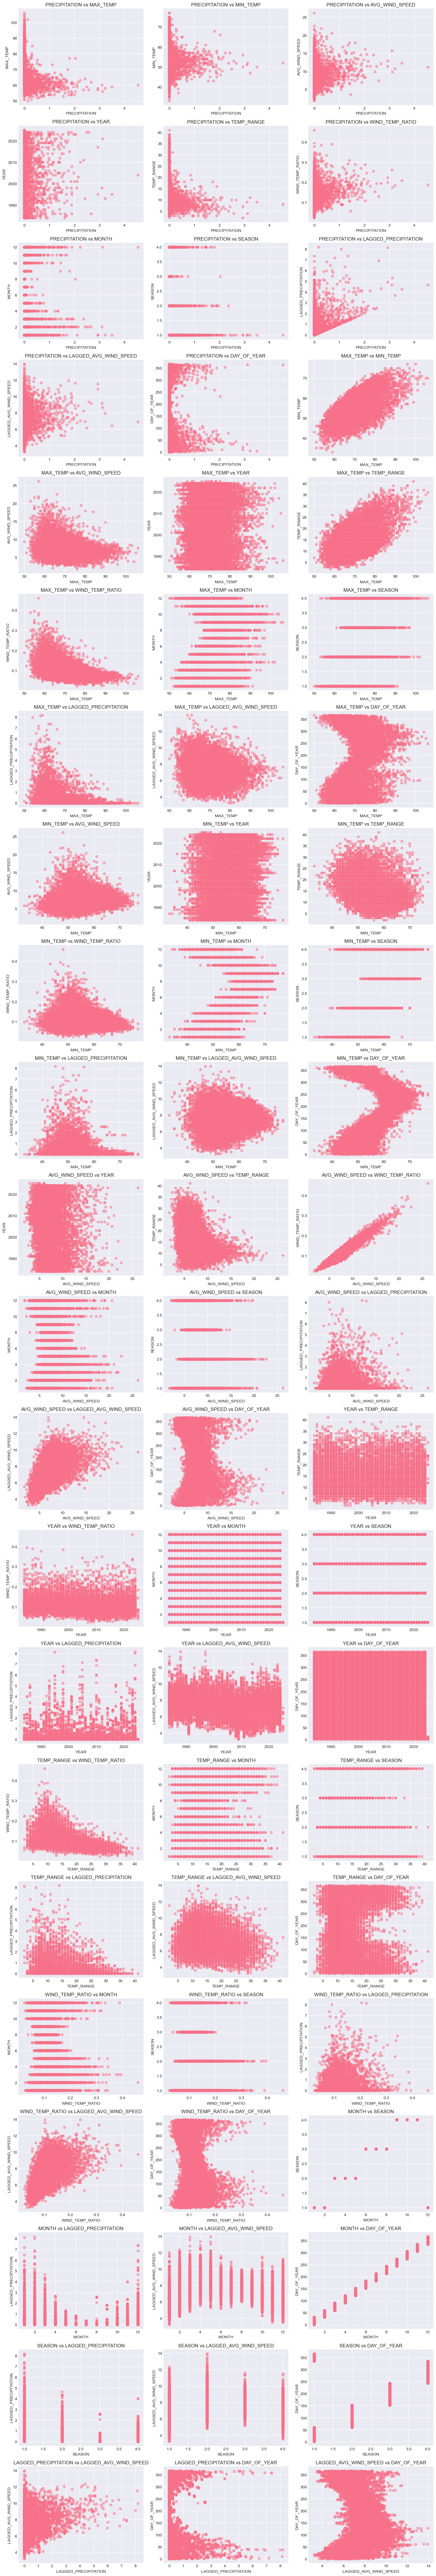

In [32]:
# Create scatter plots for all pairs of features in a grid of subplots
n_features = len(features)
n_plots = (n_features * (n_features - 1)) // 2

# Choose subplot grid size (try to keep it square-ish)
n_cols = min(3, math.ceil(math.sqrt(n_plots)))
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

plot_idx = 0
for i in range(n_features):
    for j in range(i+1, n_features):
        ax = axes[plot_idx]
        ax.scatter(
            df_fire_occurrence[features[i]],
            df_fire_occurrence[features[j]],
            alpha=0.5
        )
        ax.set_xlabel(features[i])
        ax.set_ylabel(features[j])
        ax.set_title(f"{features[i]} vs {features[j]}")
        plot_idx += 1

# Hide any unused subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

### 3.8 Temporal Analysis

In [33]:
def show_count_by_feature(df, target_feature, feature):
  # Create a wider figure to accommodate many categories
  n_categories = df[feature].nunique()
  fig_width = max(16, n_categories * 0.5)  # At least 16 inches wide, or 0.5 inches per category
  fig, ax = plt.subplots(figsize=(fig_width, 6))
  
  counts = df.groupby([
    feature, target_feature
  ]).size().unstack(fill_value=0)
  
  # Get distinct colors for each unique value of target_feature
  n_colors = len(counts.columns)
  colors = sns.color_palette("husl", n_colors)
  counts.plot(kind='bar', color=colors, alpha=0.7, ax=ax, width=0.8)
  
  ax.set_xlabel(feature, fontweight='bold', fontsize=12)
  ax.set_ylabel('Count', fontweight='bold', fontsize=12)
  
  # Rotate x-axis labels for better readability
  plt.xticks(rotation=45, ha='right')
  
  # Add grid for easier reading
  ax.grid(axis='y', alpha=0.3, linestyle='--')
  
  # Adjust layout to use full width
  plt.tight_layout()
  plt.show()

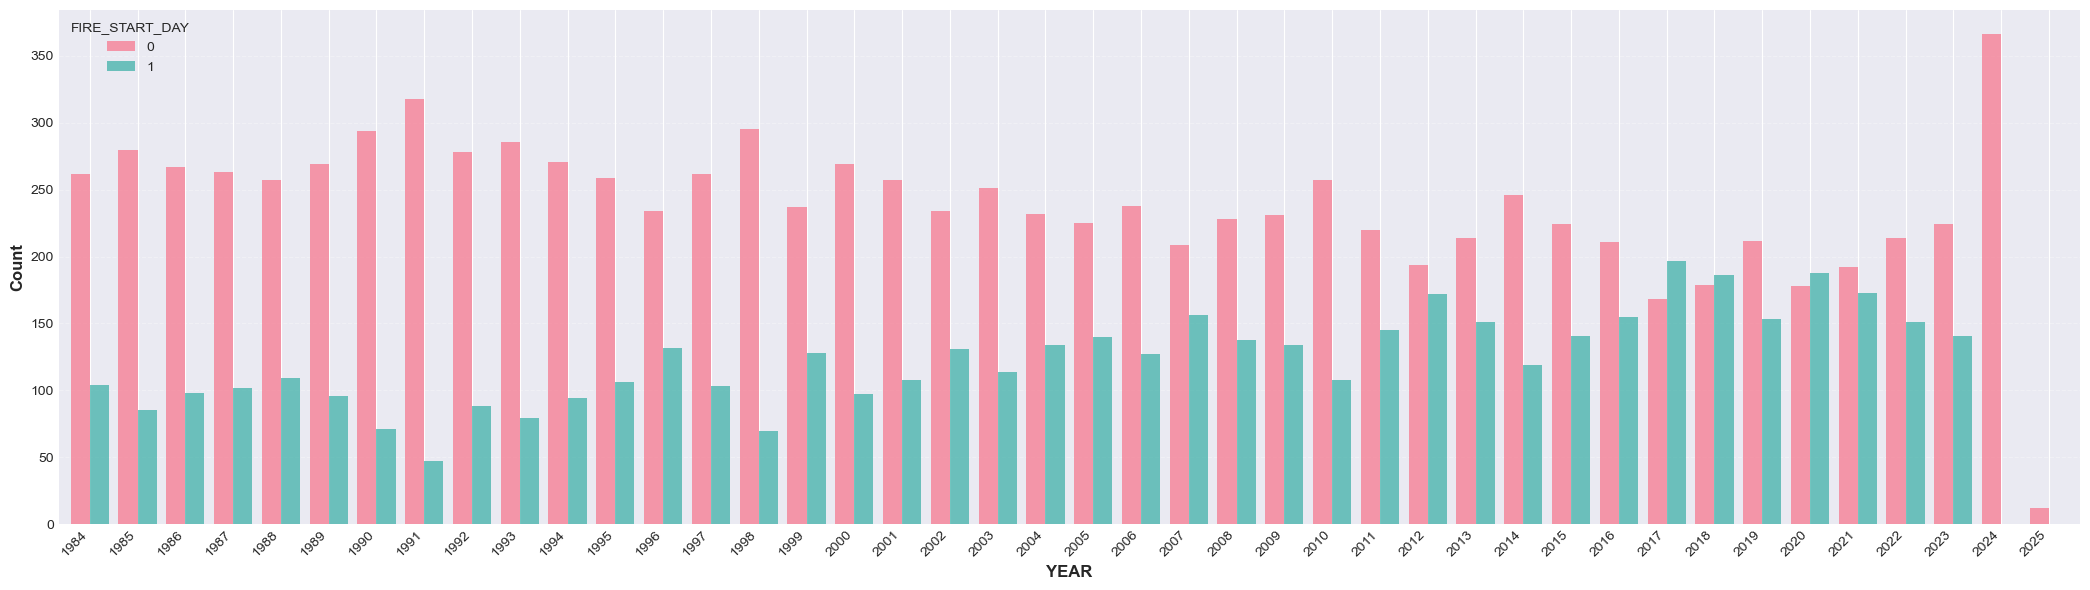

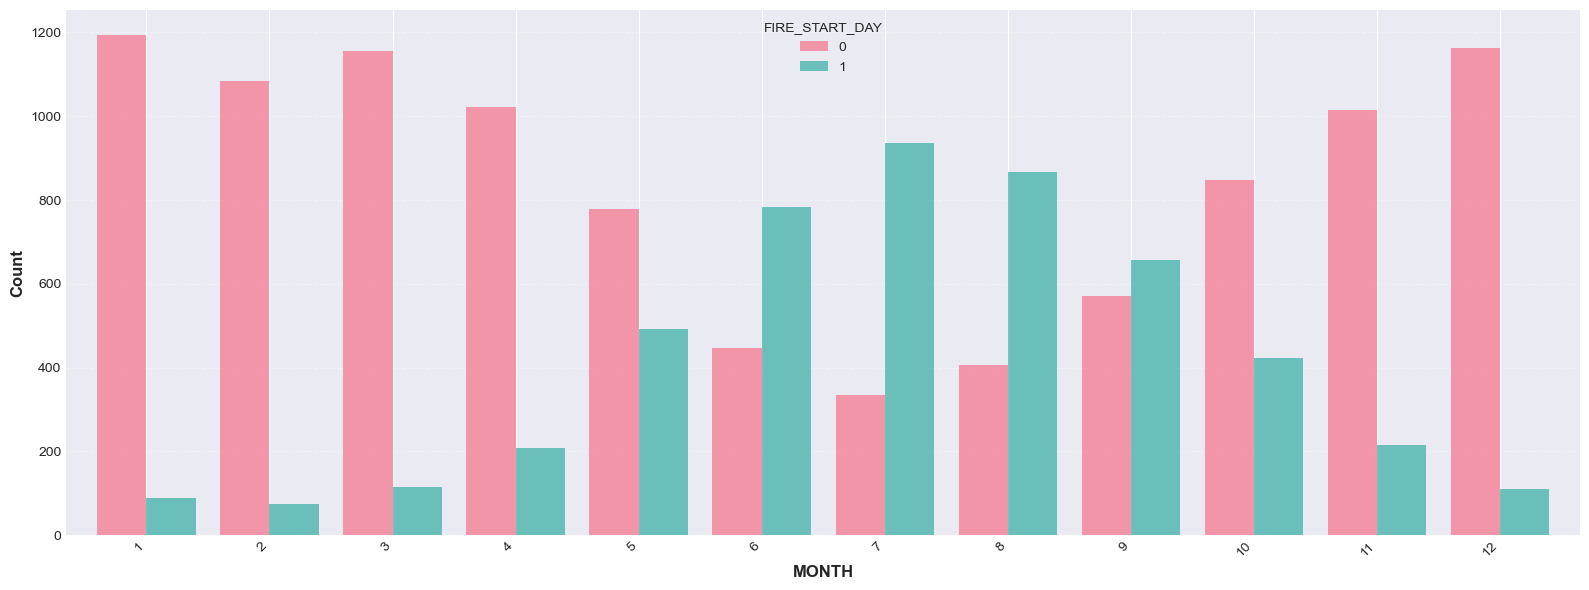

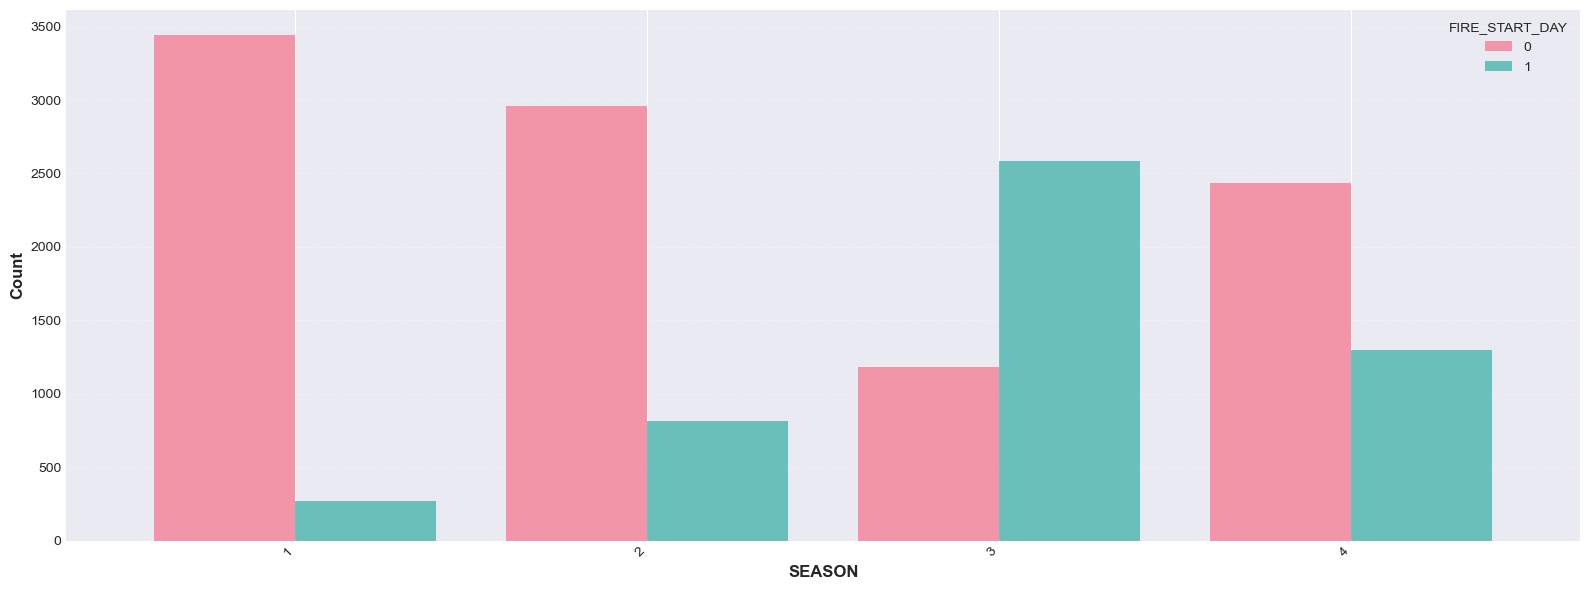

In [37]:
show_count_by_feature(df_fire_occurrence, 'FIRE_START_DAY', 'YEAR')
show_count_by_feature(df_fire_occurrence, 'FIRE_START_DAY', 'MONTH')
show_count_by_feature(df_fire_occurrence, 'FIRE_START_DAY', 'SEASON')

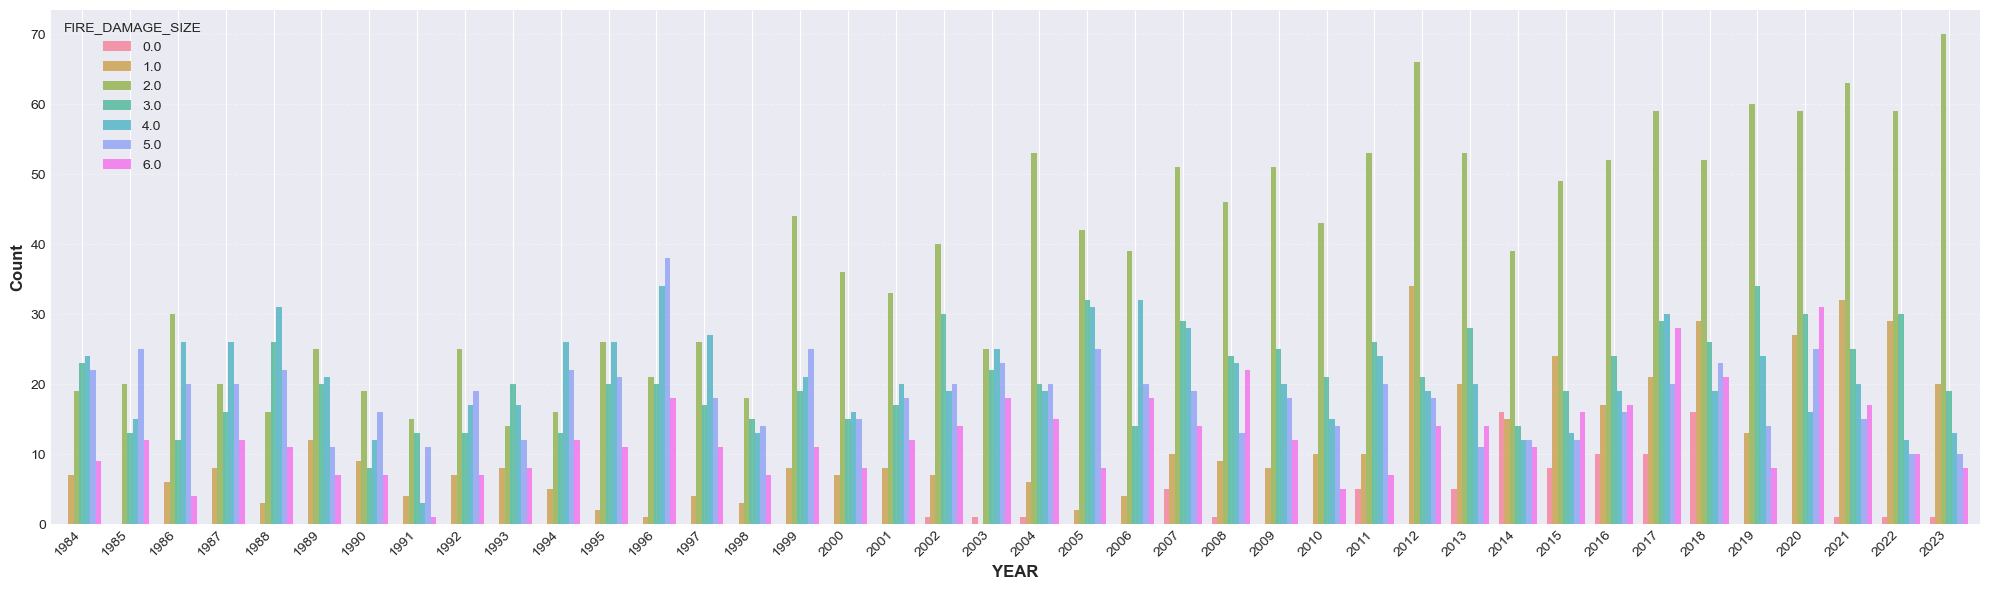

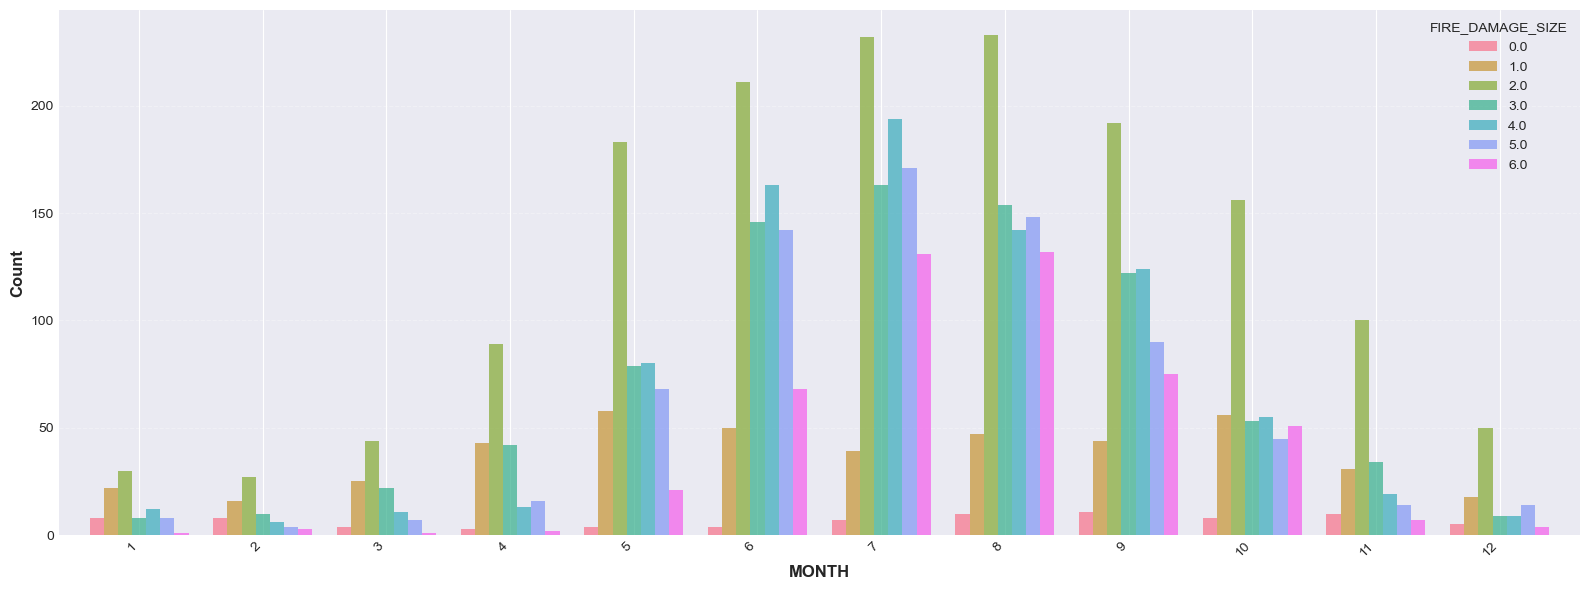

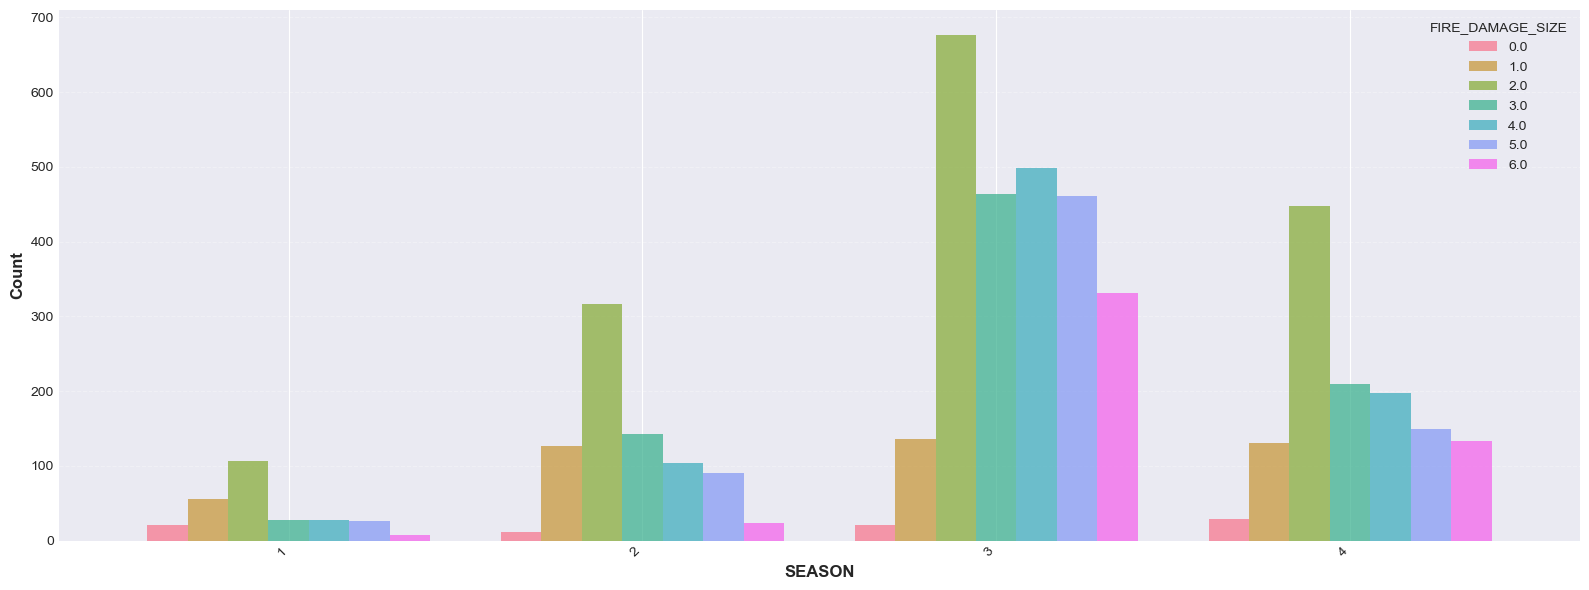

In [38]:
show_count_by_feature(df_fire_damage, 'FIRE_DAMAGE_SIZE', 'YEAR')
show_count_by_feature(df_fire_damage, 'FIRE_DAMAGE_SIZE', 'MONTH')
show_count_by_feature(df_fire_damage, 'FIRE_DAMAGE_SIZE', 'SEASON')

## 4. Feature Engineering

### 4.1 Create New Features

In [34]:
def add_engineered_features(df):
  # Create new binary features for:
  df_fe = pd.DataFrame()

  df_fe['LAGGED_PRECIPITATION_MAX_TEMP'] = df['LAGGED_PRECIPITATION'] * df['MAX_TEMP']
  df_fe['LAGGED_WIND_MAX_TEMP'] = df['LAGGED_AVG_WIND_SPEED'] * df['MAX_TEMP']
  df_fe['WIND_PRECIPITATION_INTERACTION'] = df['AVG_WIND_SPEED'] * df['PRECIPITATION']
  df_fe['MIN_TEMP_PRECIPITATION_INTERACTION'] = df['MIN_TEMP'] * df['PRECIPITATION']

  non_date_features = [
    feature for feature in features 
    if feature != "YEAR" and feature != "MONTH" and feature != "SEASON" and feature != "DAY_OF_YEAR"
  ]

  for feature in non_date_features:
    df_fe[f'HIGH_{feature}_FOR_SEASON_YEAR'] = (
      df[feature] > 
      df.groupby(['SEASON', 'YEAR'])[feature].transform('mean')
    ).astype(int)

  # Drought indicators
  df_fe['DAYS_WITHOUT_RAIN'] = (df['PRECIPITATION'] == 0).groupby(
      (df['PRECIPITATION'] > 0).cumsum()
  ).cumsum()

  # Heat wave indicator
  df_fe['HEAT_WAVE'] = (
      (df['MAX_TEMP'] > df.groupby('MONTH')['MAX_TEMP'].transform('quantile', 0.90)) &
      (df['MAX_TEMP'].rolling(3).mean() > df.groupby('MONTH')['MAX_TEMP'].transform('mean'))
  ).astype(int)

  # Compound risk: hot + dry + windy
  df_fe['EXTREME_FIRE_WEATHER'] = (
      (df['MAX_TEMP'] > df['MAX_TEMP'].quantile(0.75)) &
      (df['PRECIPITATION'] == 0) &
      (df['AVG_WIND_SPEED'] > df['AVG_WIND_SPEED'].quantile(0.75))
  ).astype(int)

  # Temperature range (diurnal variation)
  df_fe['TEMP_RANGE_NORMALIZED'] = (
      df['TEMP_RANGE'] / df.groupby('SEASON')['TEMP_RANGE'].transform('max')
  )

  # Polynomial features for top predictors: min_temp, max_temp, avg_wind_speed
  # compute polynomial features from the source dataframe (df) not from df_fe
  df_fe['MIN_TEMP_SQUARED'] = df['MIN_TEMP'] ** 2
  df_fe['MAX_TEMP_SQUARED'] = df['MAX_TEMP'] ** 2
  df_fe['AVG_WIND_SPEED_SQUARED'] = df['AVG_WIND_SPEED'] ** 2

  # Risk score (weighted combination): precipitation linked tomax_temp and avg_wind_speed
  df_fe['RISK_SCORE'] = (
      0.35 * (df['MAX_TEMP'] / df['MAX_TEMP'].max()) +
      0.35 * (1 - df['PRECIPITATION'] / df['PRECIPITATION'].max()) +
      0.2 * (df['AVG_WIND_SPEED'] / df['AVG_WIND_SPEED'].max()) +
      0.1 * (df['TEMP_RANGE'] / df['TEMP_RANGE'].max())
  )

  # Add interactions to df
  return pd.concat([df, df_fe], axis=1)


In [35]:
df_fire_data = add_engineered_features(df_fire_data)
df_fire_occurrence = add_engineered_features(df_fire_occurrence)
df_fire_damage = add_engineered_features(df_fire_damage)

In [37]:
# Get all columns in df_fire_occurrence not in features
engineered_features = df_fire_damage.drop(
  # Remove the target features
  columns=["FIRE_START_DAY", "FIRE_DAMAGE_SIZE"],
  errors='ignore'
).select_dtypes(
  include=[np.number]
).columns.difference(features)

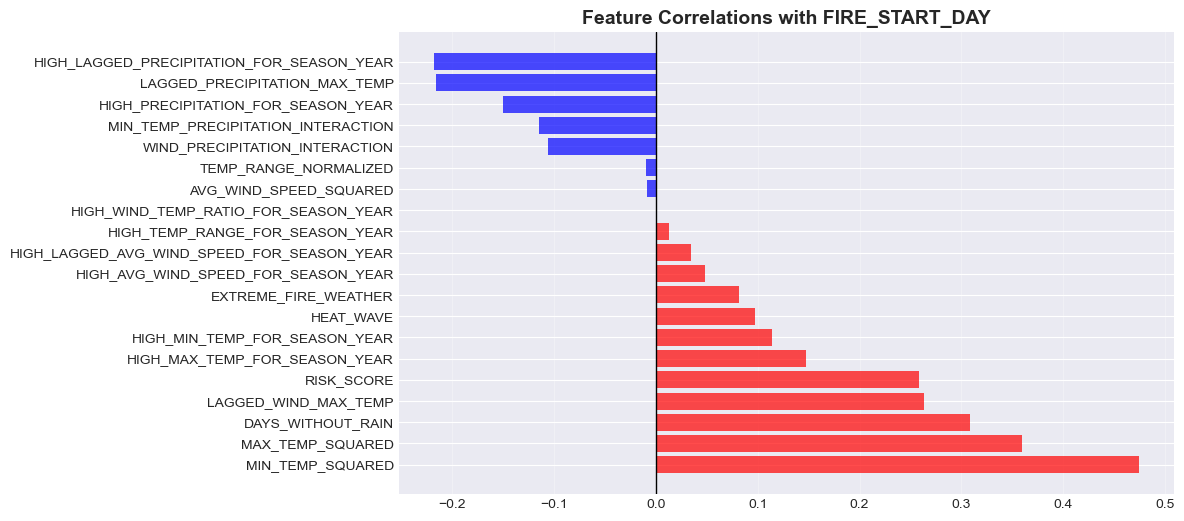

Correlation with FIRE_START_DAY:
MIN_TEMP_SQUARED                             : 0.474  (MEDIUM)
MAX_TEMP_SQUARED                             : 0.359  (MEDIUM)
DAYS_WITHOUT_RAIN                            : 0.309  (MEDIUM)
LAGGED_WIND_MAX_TEMP                         : 0.263  (WEAK)
RISK_SCORE                                   : 0.258  (WEAK)
HIGH_MAX_TEMP_FOR_SEASON_YEAR                : 0.147  (WEAK)
HIGH_MIN_TEMP_FOR_SEASON_YEAR                : 0.114  (WEAK)
HEAT_WAVE                                    : 0.097  (WEAK)
EXTREME_FIRE_WEATHER                         : 0.082  (WEAK)
HIGH_AVG_WIND_SPEED_FOR_SEASON_YEAR          : 0.048  (WEAK)
HIGH_LAGGED_AVG_WIND_SPEED_FOR_SEASON_YEAR   : 0.035  (WEAK)
HIGH_TEMP_RANGE_FOR_SEASON_YEAR              : 0.013  (WEAK)
HIGH_WIND_TEMP_RATIO_FOR_SEASON_YEAR         : 0.001  (WEAK)
AVG_WIND_SPEED_SQUARED                       : -0.009  (WEAK)
TEMP_RANGE_NORMALIZED                        : -0.010  (WEAK)
WIND_PRECIPITATION_INTERACTION              

In [38]:
df_fire_occurrence_correlation = get_correlation_strength(
  df_fire_occurrence, 'FIRE_START_DAY', engineered_features
)
visualize_correlation_analysis(df_fire_occurrence_correlation, 'FIRE_START_DAY')
print_correlation_analysis(df_fire_occurrence_correlation, 'FIRE_START_DAY')

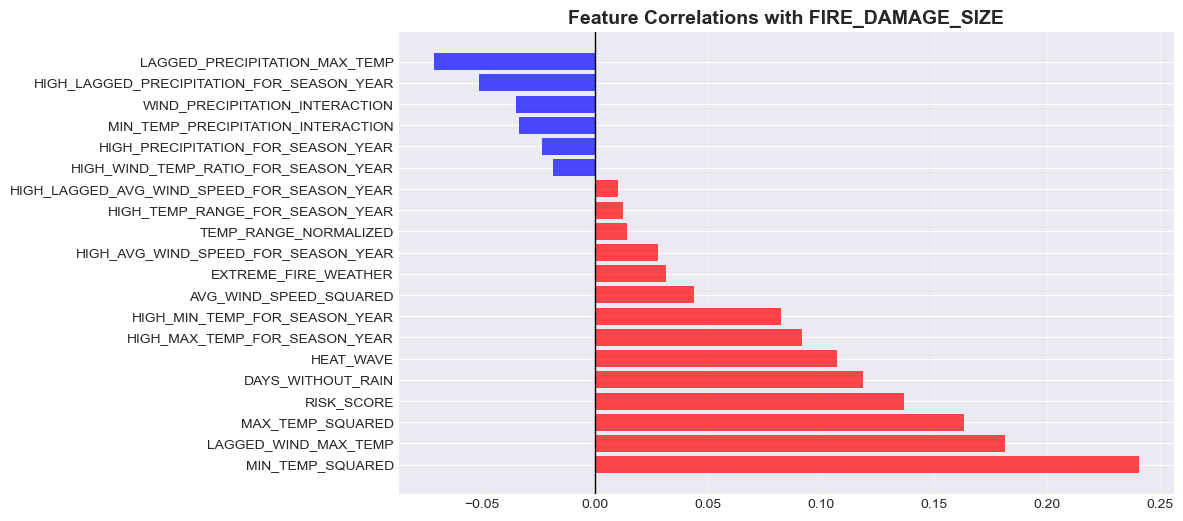

Correlation with FIRE_DAMAGE_SIZE:
MIN_TEMP_SQUARED                             : 0.240  (WEAK)
LAGGED_WIND_MAX_TEMP                         : 0.181  (WEAK)
MAX_TEMP_SQUARED                             : 0.163  (WEAK)
RISK_SCORE                                   : 0.137  (WEAK)
DAYS_WITHOUT_RAIN                            : 0.119  (WEAK)
HEAT_WAVE                                    : 0.107  (WEAK)
HIGH_MAX_TEMP_FOR_SEASON_YEAR                : 0.092  (WEAK)
HIGH_MIN_TEMP_FOR_SEASON_YEAR                : 0.082  (WEAK)
AVG_WIND_SPEED_SQUARED                       : 0.044  (WEAK)
EXTREME_FIRE_WEATHER                         : 0.032  (WEAK)
HIGH_AVG_WIND_SPEED_FOR_SEASON_YEAR          : 0.028  (WEAK)
TEMP_RANGE_NORMALIZED                        : 0.014  (WEAK)
HIGH_TEMP_RANGE_FOR_SEASON_YEAR              : 0.013  (WEAK)
HIGH_LAGGED_AVG_WIND_SPEED_FOR_SEASON_YEAR   : 0.010  (WEAK)
HIGH_WIND_TEMP_RATIO_FOR_SEASON_YEAR         : -0.019  (WEAK)
HIGH_PRECIPITATION_FOR_SEASON_YEAR           : -0

In [39]:
df_fire_damage_correlation = get_correlation_strength(
  df_fire_damage, 'FIRE_DAMAGE_SIZE', engineered_features
)
visualize_correlation_analysis(df_fire_damage_correlation, 'FIRE_DAMAGE_SIZE')
print_correlation_analysis(df_fire_damage_correlation, 'FIRE_DAMAGE_SIZE')

### 4.2 Feature Selection

In [40]:
# Redefine features value to include the engineered features
features = features.tolist() + engineered_features.tolist()

## 5. Fire Occurrence Model

### 5.1 Train-Test Split

In [41]:
# Split the data based on DATE. Find the date where the percentage of training data is 70%
df_sorted = df_fire_occurrence.sort_values('DATE').reset_index(drop=True)

# Calculate the index that gives approximately 80% of the data for training
train_size = int(len(df_sorted) * 0.80)

# Find the date at the split point
split_date = df_sorted.iloc[train_size]['DATE']

# Split the data based on the calculated date
train_data = df_fire_occurrence[df_fire_occurrence['DATE'] < split_date]
test_data = df_fire_occurrence[df_fire_occurrence['DATE'] >= split_date]

# Print the percentage with 2 decimal places
percent_train = round((len(train_data) / len(df_fire_occurrence)) * 100, 2)
percent_test = round((len(test_data) / len(df_fire_occurrence)) * 100, 2)

# Print the split date for reference
print(f"Split date: {split_date}")
print("percent of training data:", str(percent_train) + "%")
print("percent of testing data:", str(percent_test) + "%")

X_train = train_data[features]
y_train = train_data['FIRE_START_DAY']
X_test = test_data[features]
y_test = test_data['FIRE_START_DAY']

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("\nTraining set distribution:")
print(y_train.value_counts())
print("\nTest set distribution:")
print(y_test.value_counts())

Split date: 2016-10-29 00:00:00
percent of training data: 80.0%
percent of testing data: 20.0%
Training set size: 11990
Test set size: 2998

Training set distribution:
FIRE_START_DAY
0    8218
1    3772
Name: count, dtype: int64

Test set distribution:
FIRE_START_DAY
0    1799
1    1199
Name: count, dtype: int64


### 5.2 Feature Scaling

In [42]:
# Standardize features (important for KNN and clustering)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

print("Features scaled successfully!")
X_train_scaled_df.describe().T.round(2)

Features scaled successfully!


count  mean  std   min   25%  \
PRECIPITATION                               11990.0   0.0  1.0 -0.18 -0.18   
MAX_TEMP                                    11990.0   0.0  1.0 -2.83 -0.75   
MIN_TEMP                                    11990.0   0.0  1.0 -3.47 -0.80   
AVG_WIND_SPEED                              11990.0   0.0  1.0 -2.67 -0.67   
YEAR                                        11990.0  -0.0  1.0 -1.68 -0.84   
TEMP_RANGE                                  11990.0   0.0  1.0 -2.01 -0.67   
WIND_TEMP_RATIO                             11990.0  -0.0  1.0 -2.37 -0.61   
MONTH                                       11990.0  -0.0  1.0 -1.60 -0.73   
SEASON                                      11990.0   0.0  1.0 -1.35 -0.45   
LAGGED_PRECIPITATION                        11990.0   0.0  1.0 -0.35 -0.35   
LAGGED_AVG_WIND_SPEED                       11990.0  -0.0  1.0 -3.04 -0.65   
DAY_OF_YEAR                                 11990.0   0.0  1.0 -1.72 -0.87   
AVG_WIND_SPEED_SQUARED                      11990.0   0.0  1.0 -1.46 -0.60   
DAYS_WITHOUT_RAIN                           11990.0   0.0  1.0 -0.81 -0.70   
EXTREME_FIRE_WEATHER                        11990.0   0.0  1.0 -0.16 -0.16   
HEAT_WAVE                                   11990.0   0.0  1.0 -0.32 -0.32   
HIGH_AVG_WIND_SPEED_FOR_SEASON_YEAR         11990.0  -0.0  1.0 -0.85 -0.85   
HIGH_LAGGED_AVG_WIND_SPEED_FOR_SEASON_YEAR  11990.0  -0.0  1.0 -0.94 -0.94   
HIGH_LAGGED_PRECIPITATION_FOR_SEASON_YEAR   11990.0  -0.0  1.0 -0.49 -0.49   
HIGH_MAX_TEMP_FOR_SEASON_YEAR               11990.0  -0.0  1.0 -0.86 -0.86   
HIGH_MIN_TEMP_FOR_SEASON_YEAR               11990.0   0.0  1.0 -1.05 -1.05   
HIGH_PRECIPITATION_FOR_SEASON_YEAR          11990.0   0.0  1.0 -0.28 -0.28   
HIGH_TEMP_RANGE_FOR_SEASON_YEAR             11990.0  -0.0  1.0 -0.85 -0.85   
HIGH_WIND_TEMP_RATIO_FOR_SEASON_YEAR        11990.0   0.0  1.0 -0.84 -0.84   
LAGGED_PRECIPITATION_MAX_TEMP               11990.0  -0.0  1.0 -0.36 -0.36   
LAGGED_WIND_MAX_TEMP                        11990.0   0.0  1.0 -2.99 -0.68   
MAX_TEMP_SQUARED                            11990.0   0.0  1.0 -2.41 -0.75   
MIN_TEMP_PRECIPITATION_INTERACTION          11990.0   0.0  1.0 -0.18 -0.18   
MIN_TEMP_SQUARED                            11990.0   0.0  1.0 -2.84 -0.83   
RISK_SCORE                                  11990.0  -0.0  1.0 -9.83 -0.58   
TEMP_RANGE_NORMALIZED                       11990.0  -0.0  1.0 -2.11 -0.67   
WIND_PRECIPITATION_INTERACTION              11990.0  -0.0  1.0 -0.16 -0.16   

                                             50%   75%    max  
PRECIPITATION                              -0.18 -0.18  26.00  
MAX_TEMP                                   -0.06  0.63   4.93  
MIN_TEMP                                    0.09  0.83   3.06  
AVG_WIND_SPEED                             -0.04  0.49   7.14  
YEAR                                        0.01  0.85   1.70  
TEMP_RANGE                                 -0.34  0.50   4.50  
WIND_TEMP_RATIO                            -0.13  0.38   8.11  
MONTH                                       0.15  0.73   1.60  
SEASON                                      0.45  0.45   1.35  
LAGGED_PRECIPITATION                       -0.35 -0.22  12.65  
LAGGED_AVG_WIND_SPEED                       0.02  0.61   4.66  
DAY_OF_YEAR                                -0.00  0.86   1.75  
AVG_WIND_SPEED_SQUARED                     -0.14  0.31  11.54  
DAYS_WITHOUT_RAIN                          -0.43  0.34   5.31  
EXTREME_FIRE_WEATHER                       -0.16 -0.16   6.39  
HEAT_WAVE                                  -0.32 -0.32   3.17  
HIGH_AVG_WIND_SPEED_FOR_SEASON_YEAR        -0.85  1.18   1.18  
HIGH_LAGGED_AVG_WIND_SPEED_FOR_SEASON_YEAR -0.94  1.06   1.06  
HIGH_LAGGED_PRECIPITATION_FOR_SEASON_YEAR  -0.49 -0.49   2.03  
HIGH_MAX_TEMP_FOR_SEASON_YEAR              -0.86  1.16   1.16  
HIGH_MIN_TEMP_FOR_SEASON_YEAR               0.96  0.96   0.96  
HIGH_PRECIPITATION_FOR_SEASON_YEAR         -0.28 -0.28   3.60  

### 5.3 K-Means Clustering

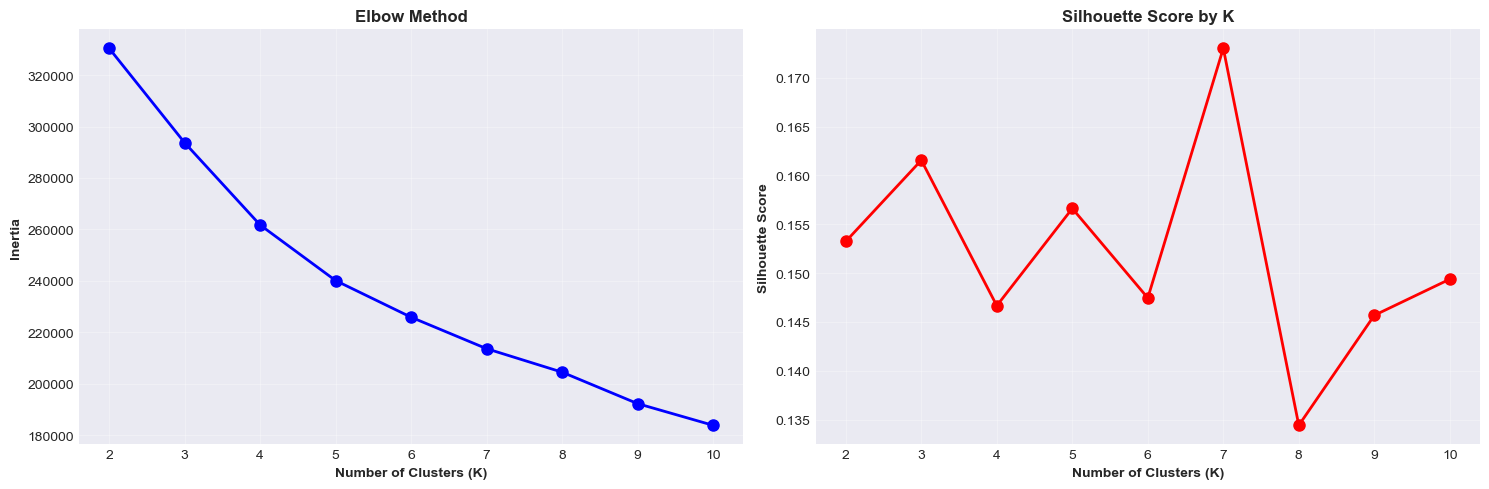

Best K (by silhouette score): 7
Silhouette score: 0.173


In [43]:
# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[0].set_ylabel('Inertia', fontweight='bold')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontweight='bold')
axes[1].set_title('Silhouette Score by K', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best K (by silhouette score): {best_k}")
print(f"Silhouette score: {max(silhouette_scores):.3f}")

In [44]:
# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_scaled)

# Add cluster labels to training data
X_train_clustered = X_train.copy()
X_train_clustered['Cluster'] = clusters
X_train_clustered['True_Class'] = y_train.values

# Evaluate clustering
sil_score = silhouette_score(X_train_scaled, clusters)
db_score = davies_bouldin_score(X_train_scaled, clusters)

print("K-Means Clustering Results:")
print("="*60)
print(f"Number of clusters: {best_k}")
print(f"Silhouette Score: {sil_score:.3f} (higher is better, max=1)")
print(f"Davies-Bouldin Score: {db_score:.3f} (lower is better)")

# Compare clusters with actual fire classes
print("\nCluster vs Actual Fire Class:")
crosstab = pd.crosstab(
  X_train_clustered['Cluster'],
  X_train_clustered['True_Class'], 
  rownames=['Cluster'],
  colnames=['Fire Class']
)
print(crosstab)

# Calculate cluster purity
purity = sum(crosstab.max(axis=1)) / len(clusters)
print(f"\nCluster Purity: {purity:.3f} (1.0 = perfect clustering)")

K-Means Clustering Results:
Number of clusters: 7
Silhouette Score: 0.173 (higher is better, max=1)
Davies-Bouldin Score: 1.604 (lower is better)

Cluster vs Actual Fire Class:
Fire Class     0     1
Cluster               
0            287     3
1           1490   221
2            682   500
3           2270   282
4            127   160
5           1477   217
6           1885  2389

Cluster Purity: 0.730 (1.0 = perfect clustering)


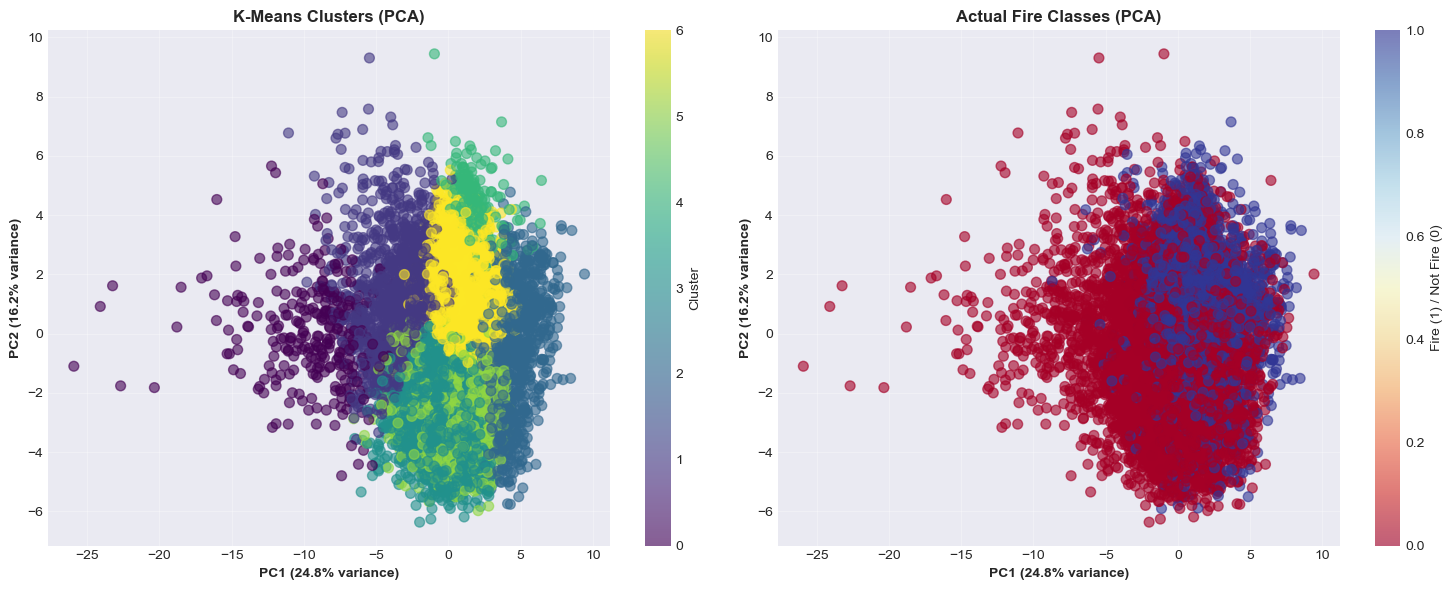


💡 PCA explains 41.0% of variance with 2 components


In [45]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot by cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[0].set_title('K-Means Clusters (PCA)', fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(alpha=0.3)

# Plot by actual class
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train.values, 
                          cmap='RdYlBu', alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[1].set_title('Actual Fire Classes (PCA)', fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Fire (1) / Not Fire (0)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 PCA explains {pca.explained_variance_ratio_.sum():.1%} of variance with {pca.n_components_} components")

### 5.4 Hierarchical Clustering

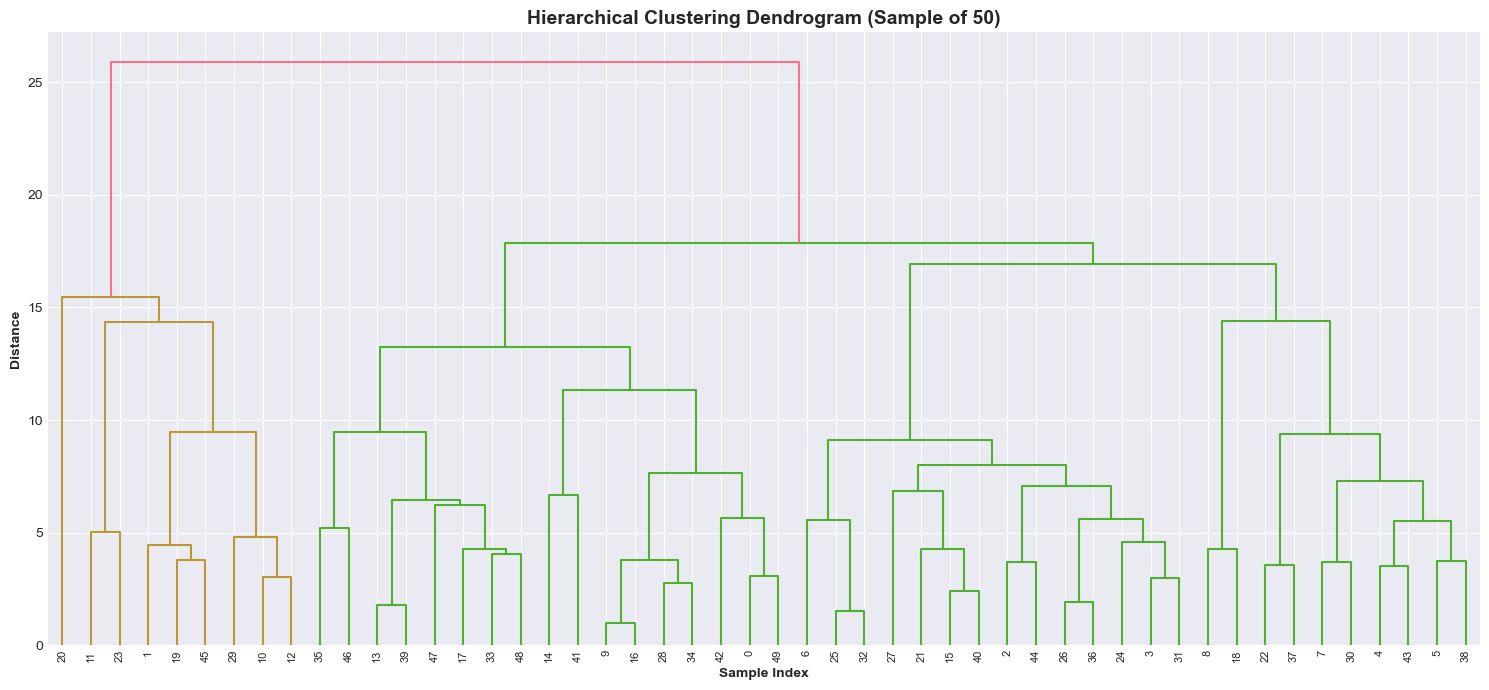


Hierarchical Clustering vs Actual:
Fire Class     0     1
Cluster               
0           5707  3486
1           2511   286


In [46]:
# Hierarchical clustering (using a sample for dendrogram)
from scipy.cluster.hierarchy import dendrogram, linkage

# Use a sample for visualization (dendrogram gets messy with too many points)
sample_size = 50
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]

# Compute linkage
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Sample of 50)', fontweight='bold', fontsize=14)
plt.xlabel('Sample Index', fontweight='bold')
plt.ylabel('Distance', fontweight='bold')
plt.tight_layout()
plt.show()

# Apply hierarchical clustering
hier_clust = AgglomerativeClustering(n_clusters=2)
hier_labels = hier_clust.fit_predict(X_train_scaled)

# Compare with actual classes
print("\nHierarchical Clustering vs Actual:")
print(pd.crosstab(
  hier_labels,
  y_train.values, 
  rownames=['Cluster'],
  colnames=['Fire Class'])
)

# Print the accur

### 5.5. K-Nearest Neighbors (KNN) Classification

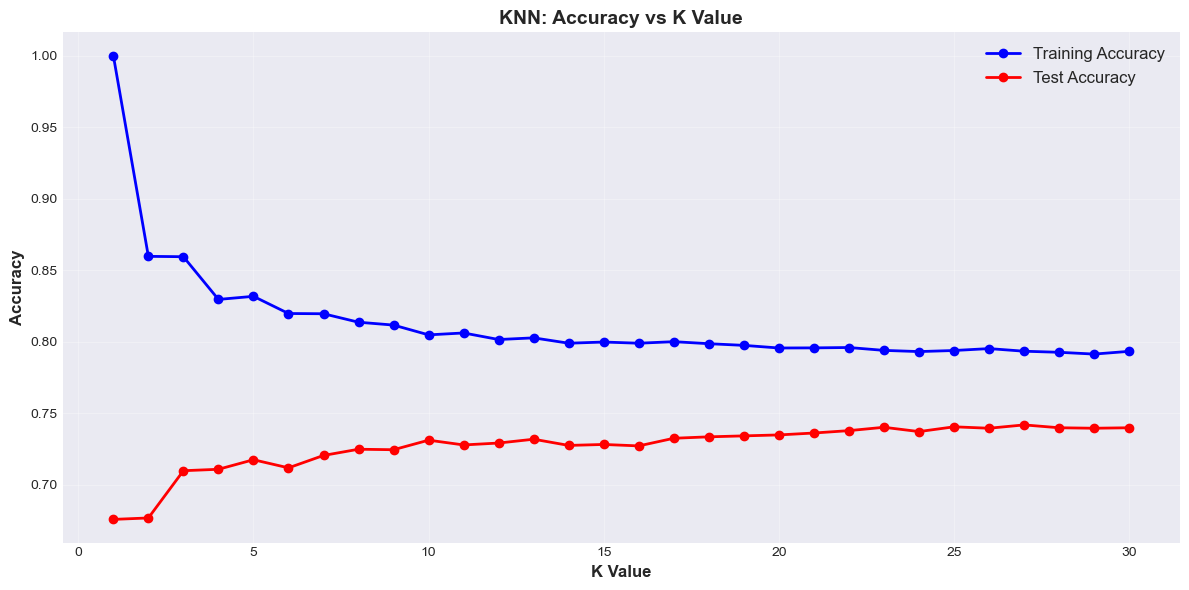

Best K: 27
  - Test Accuracy: 0.742
  - Training Accuracy: 0.793


In [47]:
# Test different K values
k_values = range(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

# Plot accuracy vs K
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, 'bo-', label='Training Accuracy', linewidth=2, markersize=6)
plt.plot(k_values, test_scores, 'ro-', label='Test Accuracy', linewidth=2, markersize=6)
plt.xlabel('K Value', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.title('KNN: Accuracy vs K Value', fontweight='bold', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find best K
best_k_idx = np.argmax(test_scores)
best_k = list(k_values)[best_k_idx]
best_accuracy = test_scores[best_k_idx]

print(f"Best K: {best_k}")
print(f"  - Test Accuracy: {best_accuracy:.3f}")
print(f"  - Training Accuracy: {train_scores[best_k_idx]:.3f}")

In [59]:
# Train KNN with optimal K
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_knn = knn_final.predict(X_train_scaled)
y_test_pred_knn = knn_final.predict(X_test_scaled)

# Probabilities for ROC curve
y_test_proba_knn = knn_final.predict_proba(X_test_scaled)[:, 1]

print("KNN Model Performance:")
print(f"  - Training Accuracy: {accuracy_score(y_train, y_train_pred_knn):.3f}")
print(f"  - Test Accuracy:     {accuracy_score(y_test, y_test_pred_knn):.3f}")
print(f"  - Precision:         {precision_score(y_test, y_test_pred_knn):.3f}")
print(f"  - Recall:            {recall_score(y_test, y_test_pred_knn):.3f}")
print(f"  - F1-Score:          {f1_score(y_test, y_test_pred_knn):.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_knn))

KNN Model Performance:
  - Training Accuracy: 0.793
  - Test Accuracy:     0.742
  - Precision:         0.687
  - Recall:            0.651
  - F1-Score:          0.668

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1799
           1       0.69      0.65      0.67      1199

    accuracy                           0.74      2998
   macro avg       0.73      0.73      0.73      2998
weighted avg       0.74      0.74      0.74      2998



### 5.6 Logistic Regression

In [48]:
# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

y_pred_lr = logreg.predict(X_test_scaled)
y_proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Performance:")
print(f"  - Accuracy:  {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_lr):.3f}")
print(f"  - Recall:    {recall_score(y_test, y_pred_lr):.3f}")
print(f"  - F1-Score:  {f1_score(y_test, y_pred_lr):.3f}")
print(f"  - AUC:       {roc_auc_score(y_test, y_proba_lr):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
  - Accuracy:  0.736
  - Precision: 0.658
  - Recall:    0.711
  - F1-Score:  0.683
  - AUC:       0.806

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1799
           1       0.66      0.71      0.68      1199

    accuracy                           0.74      2998
   macro avg       0.73      0.73      0.73      2998
weighted avg       0.74      0.74      0.74      2998



### 5.7 Decision Tree

In [49]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train_scaled, y_train)

y_pred_dt = dt.predict(X_test_scaled)
y_proba_dt = dt.predict_proba(X_test_scaled)[:, 1]

print("Decision Tree Performance:")
print(f"  - Accuracy:  {accuracy_score(y_test, y_pred_dt):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_dt):.3f}")
print(f"  - Recall:    {recall_score(y_test, y_pred_dt):.3f}")
print(f"  - F1-Score:  {f1_score(y_test, y_pred_dt):.3f}")
print(f"  - AUC:       {roc_auc_score(y_test, y_proba_dt):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Performance:
  - Accuracy:  0.748
  - Precision: 0.724
  - Recall:    0.599
  - F1-Score:  0.655
  - AUC:       0.801

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80      1799
           1       0.72      0.60      0.66      1199

    accuracy                           0.75      2998
   macro avg       0.74      0.72      0.73      2998
weighted avg       0.75      0.75      0.74      2998



### 5.8 Random Forest

In [50]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Performance:")
print(f"  - Accuracy:  {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_rf):.3f}")
print(f"  - Recall:    {recall_score(y_test, y_pred_rf):.3f}")
print(f"  - F1-Score:  {f1_score(y_test, y_pred_rf):.3f}")
print(f"  - AUC:       {roc_auc_score(y_test, y_proba_rf):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:
  - Accuracy:  0.746
  - Precision: 0.717
  - Recall:    0.605
  - F1-Score:  0.656
  - AUC:       0.821

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1799
           1       0.72      0.60      0.66      1199

    accuracy                           0.75      2998
   macro avg       0.74      0.72      0.73      2998
weighted avg       0.74      0.75      0.74      2998



### 5.9 Support Vector Machine

In [51]:
# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

print("SVM Performance:")
print(f"  - Accuracy:  {accuracy_score(y_test, y_pred_svm):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_svm):.3f}")
print(f"  - Recall:    {recall_score(y_test, y_pred_svm):.3f}")
print(f"  - F1-Score:  {f1_score(y_test, y_pred_svm):.3f}")
print(f"  - AUC:       {roc_auc_score(y_test, y_proba_svm):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Performance:
  - Accuracy:  0.739
  - Precision: 0.703
  - Recall:    0.603
  - F1-Score:  0.649
  - AUC:       0.789

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1799
           1       0.70      0.60      0.65      1199

    accuracy                           0.74      2998
   macro avg       0.73      0.72      0.72      2998
weighted avg       0.74      0.74      0.74      2998



### 5.10 XGBoost

In [52]:
xgb_occurrence = XGBClassifier(
  n_estimators=100,
  max_depth=6,
  learning_rate=0.1,
  random_state=42,
  use_label_encoder=False,
  eval_metric='logloss',
  scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()  # Handle class imbalance
)

xgb_occurrence.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_occurrence.predict(X_test_scaled)
y_proba_xgb = xgb_occurrence.predict_proba(X_test_scaled)[:, 1]

# Metrics
print("XGBoost Performance:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_xgb):.3f}")
print(f"  - Recall: {recall_score(y_test, y_pred_xgb):.3f}")
print(f"  - F1-Score: {f1_score(y_test, y_pred_xgb):.3f}")
print(f"  - AUC: {roc_auc_score(y_test, y_proba_xgb):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:
  - Accuracy: 0.742
  - Precision: 0.651
  - Recall: 0.762
  - F1-Score: 0.703
  - AUC: 0.818

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77      1799
           1       0.65      0.76      0.70      1199

    accuracy                           0.74      2998
   macro avg       0.74      0.75      0.74      2998
weighted avg       0.75      0.74      0.74      2998



### 5.11 Performance Comparison

In [60]:
# Create comparison dataframe
models_comparison = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_knn),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_knn),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_svm),
        precision_score(y_test, y_pred_xgb)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_knn),
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_svm),
        recall_score(y_test, y_pred_xgb)
    ],
    'F1-Score': [
        f1_score(y_test, y_test_pred_knn),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_svm),
        f1_score(y_test, y_pred_xgb)
    ],
    'AUC': [
        roc_auc_score(y_test, y_test_proba_knn),
        roc_auc_score(y_test, y_proba_lr),
        roc_auc_score(y_test, y_proba_dt),
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_svm),
        roc_auc_score(y_test, y_proba_xgb)
    ]
})

# Sort by accuracy
models_comparison = models_comparison.sort_values('Accuracy', ascending=False)

print("Model Performance Comparison:")
print("="*80)
print(models_comparison.to_string(index=False))

print(f"\nBest Model: {models_comparison.iloc[0]['Model']}")
print(f"   Accuracy: {models_comparison.iloc[0]['Accuracy']:.3f}")
print(f"   AUC: {models_comparison.iloc[0]['AUC']:.3f}")

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score      AUC
      Decision Tree  0.748165   0.723790 0.598832  0.655408 0.801100
      Random Forest  0.746498   0.717112 0.604671  0.656109 0.821437
                KNN  0.741828   0.687225 0.650542  0.668380 0.799966
            XGBoost  0.741828   0.651461 0.762302  0.702537 0.817929
                SVM  0.739159   0.702624 0.603003  0.649013 0.789228
Logistic Regression  0.736491   0.657672 0.711426  0.683494 0.806365

Best Model: Decision Tree
   Accuracy: 0.748
   AUC: 0.801


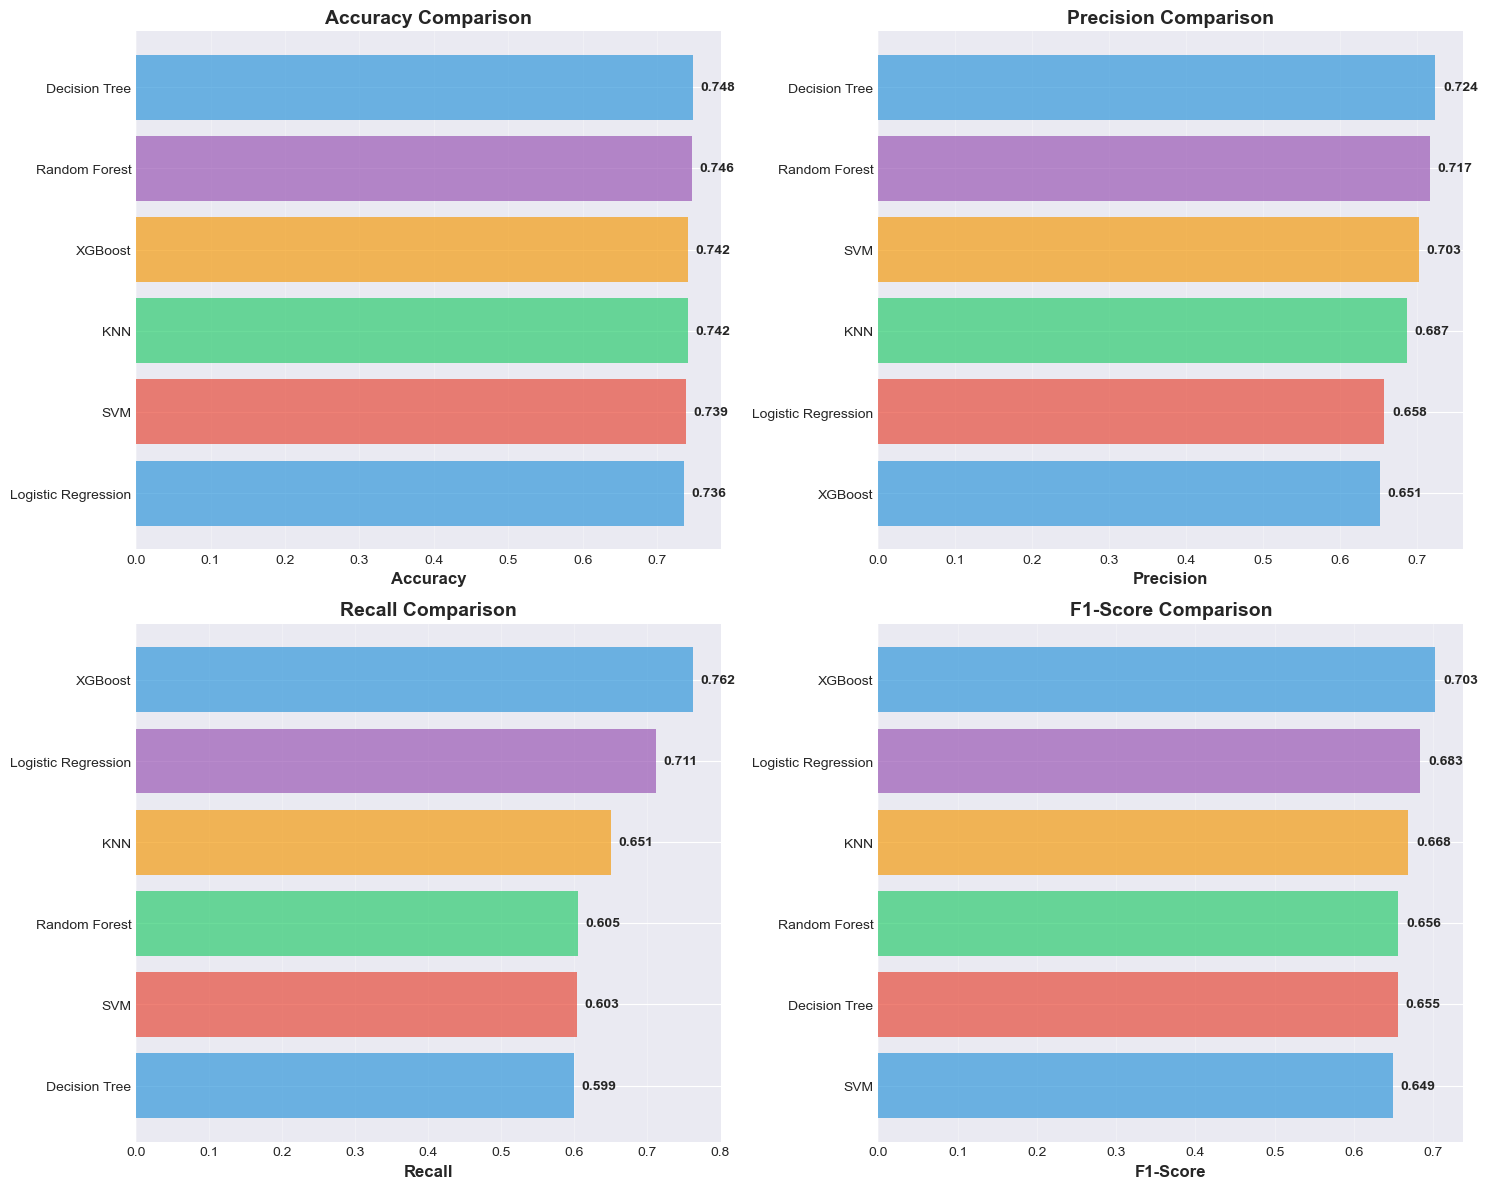

In [61]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sorted_df = models_comparison.sort_values(metric, ascending=True)
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors_palette, alpha=0.7)
    ax.set_xlabel(metric, fontweight='bold', fontsize=12)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 5.12 ROC Curves Comparison

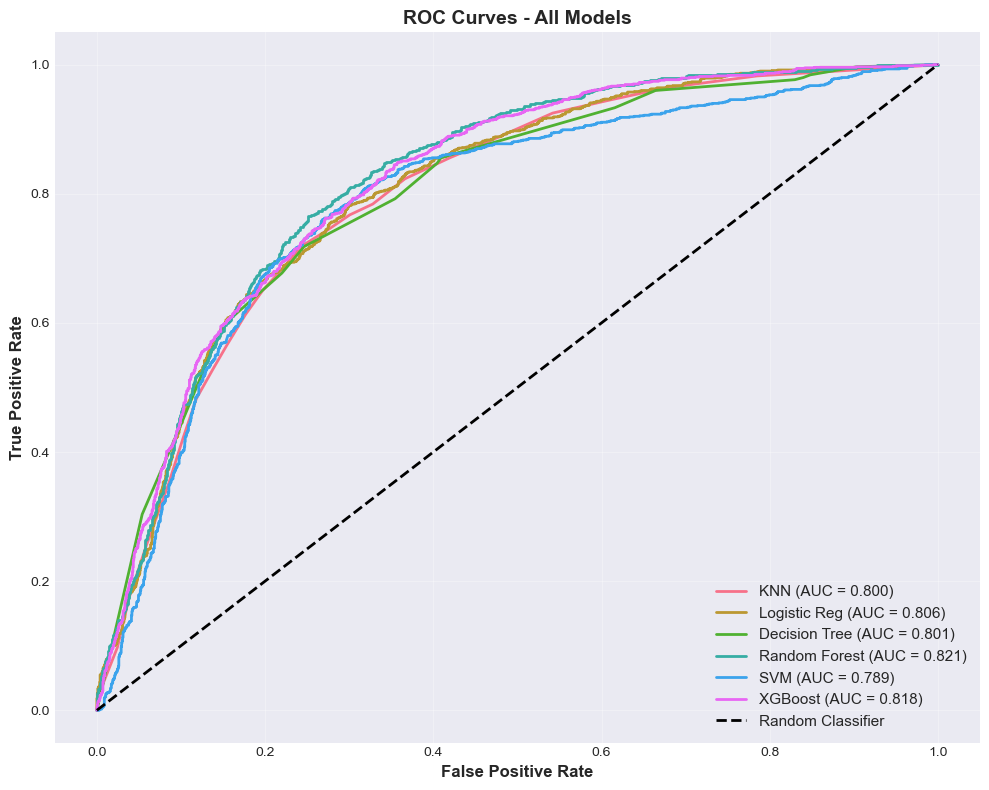

In [62]:
# Compare all ROC curves
plt.figure(figsize=(10, 8))

# KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_proba_knn)
plt.plot(fpr_knn, tpr_knn, linewidth=2, 
         label=f'KNN (AUC = {roc_auc_score(y_test, y_test_proba_knn):.3f})')

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
plt.plot(fpr_lr, tpr_lr, linewidth=2,
         label=f'Logistic Reg (AUC = {roc_auc_score(y_test, y_proba_lr):.3f})')

# Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.plot(fpr_dt, tpr_dt, linewidth=2,
         label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_proba_dt):.3f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, linewidth=2,
         label=f'Random Forest (AUC = {roc_auc_score(y_test, y_proba_rf):.3f})')

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
plt.plot(fpr_svm, tpr_svm, linewidth=2,
         label=f'SVM (AUC = {roc_auc_score(y_test, y_proba_svm):.3f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, linewidth=2,
         label=f'XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.3f})')

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves - All Models', fontweight='bold', fontsize=14)
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 5.13 Feature Importance Analysis

Feature Importance (Random Forest):
                                   Feature  Importance
                          MIN_TEMP_SQUARED    0.158562
                                  MIN_TEMP    0.110629
                               DAY_OF_YEAR    0.104150
                         DAYS_WITHOUT_RAIN    0.066312
                                    SEASON    0.063397
                          MAX_TEMP_SQUARED    0.056218
                                     MONTH    0.051675
                                      YEAR    0.051231
                      LAGGED_WIND_MAX_TEMP    0.044318
                                RISK_SCORE    0.037629
                                  MAX_TEMP    0.035678
                     LAGGED_AVG_WIND_SPEED    0.033646
                           WIND_TEMP_RATIO    0.027351
                      LAGGED_PRECIPITATION    0.024957
                     TEMP_RANGE_NORMALIZED    0.021426
             LAGGED_PRECIPITATION_MAX_TEMP    0.020742
                            A

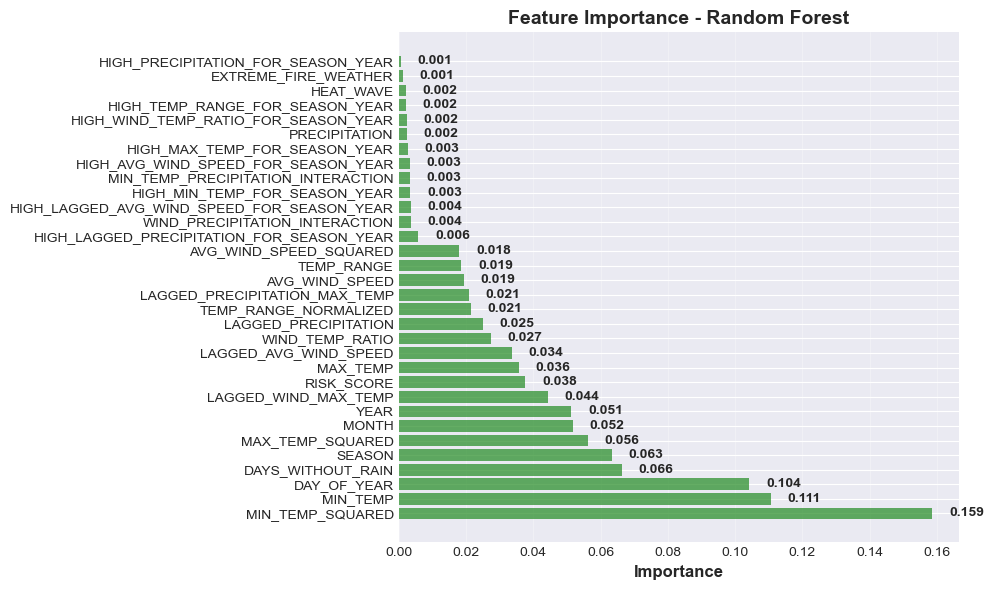


💡 Most important feature: MIN_TEMP_SQUARED


In [63]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], 
         color='forestgreen', alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Feature Importance - Random Forest', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add values
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Most important feature: {feature_importance.iloc[0]['Feature']}")

### 5.14 Cross-Validation

5-Fold Cross-Validation Results:
KNN                 : 0.759 (+/- 0.030)
Logistic Regression : 0.754 (+/- 0.037)
Decision Tree       : 0.543 (+/- 0.112)
Random Forest       : 0.640 (+/- 0.120)
SVM                 : 0.753 (+/- 0.038)
XGBoost             : 0.421 (+/- 0.140)


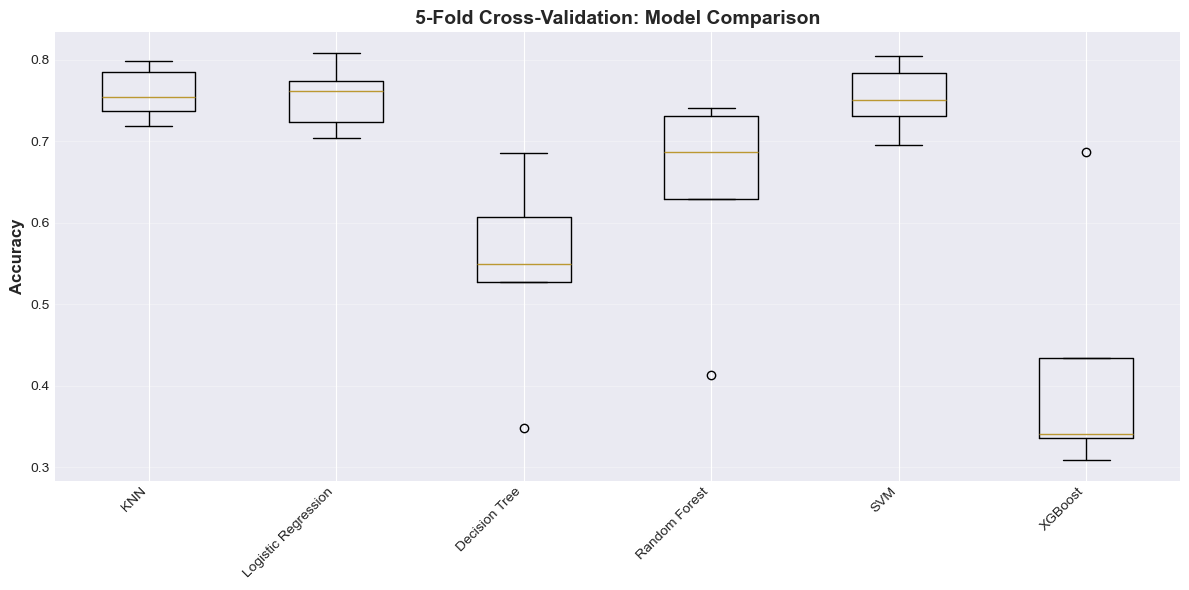

In [58]:
# Perform 5-fold cross-validation for each model
print("5-Fold Cross-Validation Results:")
print("="*60)

models = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'SVM': SVC(kernel='rbf', random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name:20s}: {scores.mean():.3f} (+/- {scores.std():.3f})")

# Visualize
plt.figure(figsize=(12, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.title('5-Fold Cross-Validation: Model Comparison', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.15 Model Results

In [64]:
print("\nCLUSTERING RESULTS:")
print(f"  - K-Means Silhouette Score: {sil_score:.3f}")
print(f"  - Cluster Purity: {purity:.3f}")
print(f"  - Clear separation between fire/not fire conditions")

print("\nCLASSIFICATION PERFORMANCE:")
best_model_row = models_comparison.iloc[0]
print(f"  - Best Model: {best_model_row['Model']}")
print(f"  - Accuracy: {best_model_row['Accuracy']:.3f}")
print(f"  - Precision: {best_model_row['Precision']:.3f}")
print(f"  - Recall: {best_model_row['Recall']:.3f}")
print(f"  - F1-Score: {best_model_row['F1-Score']:.3f}")
print(f"  - AUC: {best_model_row['AUC']:.3f}")


CLUSTERING RESULTS:
  - K-Means Silhouette Score: 0.173
  - Cluster Purity: 0.730
  - Clear separation between fire/not fire conditions

CLASSIFICATION PERFORMANCE:
  - Best Model: Decision Tree
  - Accuracy: 0.748
  - Precision: 0.724
  - Recall: 0.599
  - F1-Score: 0.655
  - AUC: 0.801


### 5.15 Hyper-parameter Tuning

In [ ]:
# Hyperparameter Tuning
#    - Using AUC_ROC scoring as the criterion

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.calibration import CalibratedClassifierCV


tuned_models = {}
tuned_results = []



### 5.15.1KNN

In [73]:
param_grid_knn = {
    "n_neighbors": list(range(1, 61)),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train_scaled_df, y_train)
tuned_models["KNN"] = grid_knn.best_estimator_

print("   Best Params:", grid_knn.best_params_, "\n")


   Best Params: {'metric': 'euclidean', 'n_neighbors': 60, 'weights': 'uniform'} 



### 5.15.2 Logistic Regression

In [74]:
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "class_weight": ["balanced"]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=3000),
    param_grid_lr,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_scaled_df, y_train)
tuned_models["Logistic Regression"] = grid_lr.best_estimator_

print("   Best Params:", grid_lr.best_params_, "\n")


   Best Params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'} 



### 5.13.3 Decision Tree

In [75]:
param_grid_dt = {
    "max_depth": [3, 5, 7, 9, 11, 13, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "class_weight": ["balanced"]
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train_scaled_df, y_train)
tuned_models["Decision Tree"] = grid_dt.best_estimator_

print("   Best Params:", grid_dt.best_params_, "\n")

   Best Params: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 2} 



### 5.13.4 Random Forest

In [76]:
param_grid_rf = {
    "n_estimators": [100, 150, 200, 250, 400],
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 6, 10],
    "class_weight": ["balanced"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train_scaled_df, y_train)
tuned_models["Random Forest"] = grid_rf.best_estimator_

print("   Best Params:", grid_rf.best_params_, "\n")

   Best Params: {'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 250} 



### 5.13.5 SVM

In [77]:
param_grid_svm = {
    "C": [0.1, 1, 5],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf"],
    "class_weight": ["balanced"]
}

grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid_svm,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_svm.fit(X_train_scaled_df, y_train)

# Calibrate
svm_best = CalibratedClassifierCV(
    estimator=grid_svm.best_estimator_,
    method="sigmoid"
)
svm_best.fit(X_train_scaled_df, y_train)

tuned_models["SVM"] = svm_best

print("   Best Params:", grid_svm.best_params_, "\n")


   Best Params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'} 



### 5.13.6 XGBoost

In [89]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Handle imbalance just like your base model:
scale_pos_wt = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_wt
)


# Parameter grid
xgb_param_grid = {
    "n_estimators": [100, 200, 300],     
    "max_depth": [3, 5, 7],              
    "learning_rate": [0.05, 0.1, 0.2],   
    "subsample": [0.7, 0.9, 1.0],        
    "colsample_bytree": [0.7, 0.9, 1.0], 
    "gamma": [0, 0.1, 0.3],             
    "min_child_weight": [1, 3, 5]
}

# GRID SEARCH 

xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit
xgb_grid.fit(X_train_scaled, y_train)

# Best estimator
xgb_best1 = xgb_grid.best_estimator_
tuned_models["XGBoost (Tuned)"] = xgb_best1

print("\nBest XGBoost Parameters:")
print(xgb_grid.best_params_)


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits

Best XGBoost Parameters:
{'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}


### 5.13.7 Model Comparison after hyperparameter tuning

In [96]:
perf_rows = []

for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test_scaled_df)
    y_proba = model.predict_proba(X_test_scaled_df)[:, 1]

    perf_rows.append([
        model_name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_proba)
    ])

tuned_results_df = pd.DataFrame(
    perf_rows,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"]
)

print(tuned_results_df.sort_values("AUC", ascending=False).to_string(index=False))

              Model  Accuracy  Precision   Recall       F1      AUC
    XGBoost (Tuned)  0.744830   0.647418 0.794829 0.713590 0.825740
      Random Forest  0.745163   0.660044 0.748123 0.701329 0.814333
                SVM  0.746831   0.688034 0.671393 0.679612 0.811416
Logistic Regression  0.689793   0.574515 0.864887 0.690413 0.807273
                KNN  0.742161   0.686189 0.654712 0.670081 0.805788
      Decision Tree  0.751167   0.696785 0.668891 0.682553 0.774239


### Threshold Tuning (not sure if it is what we should do)

In [104]:
def tune_threshold(model, X_test, y_test, 
                   precision_floor=0.30, recall_floor=0.60,
                   beta=2, plot=True):
    
    # Predicted probabilities
    y_proba = model.predict_proba(X_test)[:, 1]

    thresholds = np.arange(0.01, 1.00, 0.01)
    rows = []

    # Evaluate metrics for each threshold
    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)

        precision = precision_score(y_test, y_pred_t, zero_division=0)
        recall = recall_score(y_test, y_pred_t, zero_division=0)
        fbeta = fbeta_score(y_test, y_pred_t, beta=beta, zero_division=0)

        rows.append([t, precision, recall, fbeta])

    df = pd.DataFrame(rows, columns=["Threshold", "Precision", "Recall", f"F{beta}"])

    # Apply constraints
    df_filtered = df[
        (df["Precision"] >= precision_floor) &
        (df["Recall"] >= recall_floor)
    ]

    if df_filtered.empty:
        print("No threshold satisfies both precision and recall constraints.")
        print("Try lowering the precision_floor or recall_floor.")
        return None, None

    # Select threshold that maximizes F-beta
    best_row = df_filtered.sort_values(f"F{beta}", ascending=False).iloc[0]
    best_threshold = best_row["Threshold"]

    # Print summary
    print("Optimal threshold found:")
    print(best_row)

    # Final predictions
    y_pred_final = (y_proba >= best_threshold).astype(int)

    print("\nClassification Report at Optimal Threshold:")
    print(classification_report(y_test, y_pred_final))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_final))

    # Visualization
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(df["Threshold"], df["Precision"], label="Precision", color="blue")
        plt.plot(df["Threshold"], df["Recall"], label="Recall", color="red")
        plt.plot(df["Threshold"], df[f"F{beta}"], label=f"F{beta}", color="green")
        plt.axvline(best_threshold, color="black", linestyle="--", label="Best Threshold")

        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title("Threshold Tuning Curve")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    return best_threshold, best_row


In [ ]:
import contextlib
import io

threshold_rows = []

for model_name, model in tuned_models.items():

    # Suppress prints from tune_threshold
    with contextlib.redirect_stdout(io.StringIO()):
        best_threshold, best_row = tune_threshold(
            model, 
            X_test_scaled_df, 
            y_test,
            plot=False
        )

    # Compute predictions at tuned threshold
    y_proba = model.predict_proba(X_test_scaled_df)[:, 1]
    y_pred_tuned = (y_proba >= best_threshold).astype(int)

    threshold_rows.append([
        model_name,
        best_threshold,
        accuracy_score(y_test, y_pred_tuned),
        precision_score(y_test, y_pred_tuned, zero_division=0),
        recall_score(y_test, y_pred_tuned, zero_division=0),
        fbeta_score(y_test, y_pred_tuned, beta=2, zero_division=0),
        roc_auc_score(y_test, y_proba)
    ])

threshold_results_df = pd.DataFrame(
    threshold_rows,
    columns=["Model", "Best_Threshold", "Accuracy", "Precision", "Recall", "F2", "AUC"]
)

print("\nThreshold-Tuned Model Performance:")
print(threshold_results_df.sort_values("AUC", ascending=False).to_string(index=False))



Threshold-Tuned Model Performance:
              Model  Best_Threshold  Accuracy  Precision   Recall       F2      AUC
    XGBoost (Tuned)            0.29  0.652769   0.537299 0.949124 0.822968 0.825740
      Random Forest            0.24  0.623749   0.515941 0.958299 0.818026 0.814333
                SVM            0.12  0.600734   0.500434 0.960801 0.811496 0.811416
Logistic Regression            0.36  0.615077   0.510058 0.951626 0.811176 0.807273
                KNN            0.15  0.615077   0.510085 0.949124 0.809734 0.805788
      Decision Tree            0.16  0.538359   0.463654 0.984153 0.803705 0.774239


### 5.13.8 Feature Importance Analysis with XGBoost

Feature Importance (XGBoost):
                                   Feature  Importance
                          MIN_TEMP_SQUARED    0.303844
                                  MIN_TEMP    0.230531
                                    SEASON    0.075654
                          MAX_TEMP_SQUARED    0.037379
                                     MONTH    0.036345
                               DAY_OF_YEAR    0.033737
                                  MAX_TEMP    0.033418
             LAGGED_PRECIPITATION_MAX_TEMP    0.027759
                      LAGGED_PRECIPITATION    0.027645
                         DAYS_WITHOUT_RAIN    0.027371
                                      YEAR    0.019325
                                RISK_SCORE    0.011702
                      LAGGED_WIND_MAX_TEMP    0.010940
        MIN_TEMP_PRECIPITATION_INTERACTION    0.010570
      HIGH_WIND_TEMP_RATIO_FOR_SEASON_YEAR    0.009708
           HIGH_TEMP_RANGE_FOR_SEASON_YEAR    0.009670
            WIND_PRECIPITATION_INTE

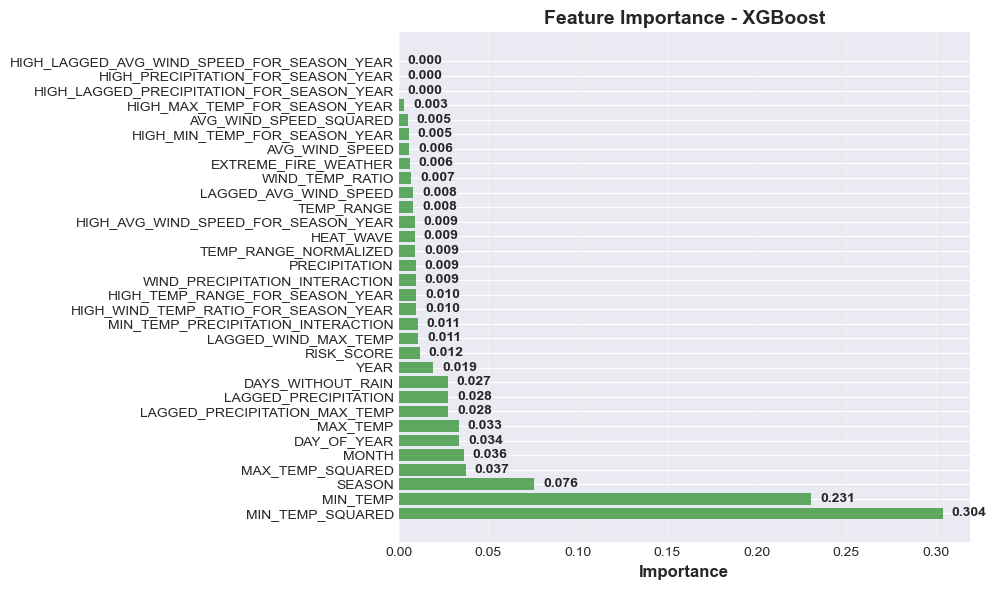


💡 Most important feature: MIN_TEMP_SQUARED


In [102]:
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (XGBoost):")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], 
         color='forestgreen', alpha=0.7)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Feature Importance - XGBoost', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add values
for i, v in enumerate(feature_importance['Importance']):
    plt.text(v + 0.005, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Most important feature: {feature_importance.iloc[0]['Feature']}")

### 5.13.8 RandomSearch with XGBoost to identify promising hyperparameters

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

scale_pos_wt = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_wt
)

param_dist = {
    "n_estimators": np.arange(200, 800, 50),
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "max_depth": np.arange(3, 10),
    "min_child_weight": np.arange(1, 10),
    "subsample": np.linspace(0.5, 1.0, 10),
    "colsample_bytree": np.linspace(0.5, 1.0, 10),
    "gamma": np.linspace(0, 0.5, 10),
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    scoring="roc_auc",
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

xgb_random.fit(X_train_scaled, y_train)

print("Best parameters from RandomizedSearchCV:")
print(xgb_random.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters from RandomizedSearchCV:
{'subsample': np.float64(0.5555555555555556), 'n_estimators': np.int64(500), 'min_child_weight': np.int64(3), 'max_depth': np.int64(9), 'learning_rate': np.float64(0.01), 'gamma': np.float64(0.2222222222222222), 'colsample_bytree': np.float64(0.6666666666666666)}


### 5.13.9 Gridsearch to fine tune

In [84]:
refined_grid = {
    "n_estimators": np.arange(start=450, stop=550, step=10),
    "learning_rate": [0.005, 0.01, 0.015, 0.25],
    "max_depth": np.arange(start=3, stop=12, step=2),
    "min_child_weight": [2,3,4],
    "subsample": [0.51, 0.56, 0.61],
    "colsample_bytree": [0.57,0.67,0.77],
    "gamma": [0.12,0.22,0.32],
}

xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=refined_grid,
    scoring="roc_auc",
    cv=3,
    verbose=1,
    n_jobs=-1,
)

xgb_grid.fit(X_train_scaled, y_train)

xgb_best = xgb_grid.best_estimator_
tuned_models["XGBoost (Tuned)"] = xgb_best

print("\nBest Parameters after GridSearchCV:")
print(xgb_grid.best_params_)


Fitting 3 folds for each of 16200 candidates, totalling 48600 fits

Best Parameters after GridSearchCV:
{'colsample_bytree': 0.57, 'gamma': 0.22, 'learning_rate': 0.005, 'max_depth': np.int64(3), 'min_child_weight': 4, 'n_estimators': np.int64(450), 'subsample': 0.56}


In [95]:
#See the result without having to run the model again:
from xgboost import XGBClassifier

# Use the same imbalance handling as before
scale_pos_wt = (y_train == 0).sum() / (y_train == 1).sum()

xgb_tuned = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_wt,

    # Best parameters from your GridSearchCV
    colsample_bytree=0.57,
    gamma=0.22,
    learning_rate=0.005,
    max_depth=3,
    min_child_weight=4,
    n_estimators=450,
    subsample=0.56
)

# Fit once — fast
xgb_tuned.fit(X_train_scaled, y_train)

y_pred_xgb_tuned = xgb_tuned.predict(X_test_scaled)
y_proba_xgb_tuned = xgb_tuned.predict_proba(X_test_scaled)[:, 1]

print("XGBoost (Tuned) Performance:")
print(f"  - Accuracy:  {accuracy_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  - Precision: {precision_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  - Recall:    {recall_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  - F1-Score:  {f1_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"  - AUC:       {roc_auc_score(y_test, y_proba_xgb_tuned):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_tuned))


XGBoost (Tuned) Performance:
  - Accuracy:  0.747
  - Precision: 0.656
  - Recall:    0.776
  - F1-Score:  0.711
  - AUC:       0.820

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1799
           1       0.66      0.78      0.71      1199

    accuracy                           0.75      2998
   macro avg       0.74      0.75      0.74      2998
weighted avg       0.76      0.75      0.75      2998



## 6. Fire Damage Model

### 6.1 Train-Test Split

In [ ]:
# Split the data based on DATE. Find the date where the percentage of training data is 70%
df_sorted = df_fire_damage.sort_values('DATE').reset_index(drop=True)

# Calculate the index that gives approximately 80% of the data for training
train_size = int(len(df_sorted) * 0.80)

# Find the date at the split point
split_date = df_sorted.iloc[train_size]['DATE']

# Split the data based on the calculated date
train_data = df_fire_damage[df_fire_damage['DATE'] < split_date]
test_data = df_fire_damage[df_fire_damage['DATE'] >= split_date]

# Print the percentage with 2 decimal places
percent_train = round((len(train_data) / len(df_fire_damage)) * 100, 2)
percent_test = round((len(test_data) / len(df_fire_damage)) * 100, 2)

# Print the split date for reference
print(f"Split date: {split_date}")
print("percent of training data:", str(percent_train) + "%")
print("percent of testing data:", str(percent_test) + "%")

X_train = train_data[features]
y_train = train_data['FIRE_DAMAGE_SIZE']
X_test = test_data[features]
y_test = test_data['FIRE_DAMAGE_SIZE']

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("\nTraining set distribution:")
print(y_train.value_counts())
print("\nTest set distribution:")
print(y_test.value_counts())

### 6.2 Feature Scaling

In [ ]:
# Standardize features (important for KNN and clustering)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

print("Features scaled successfully!")
X_train_scaled_df.describe().T.round(2)

### 6.3 K-Means Clustering

In [ ]:
# Find optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[0].set_ylabel('Inertia', fontweight='bold')
axes[0].set_title('Elbow Method', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontweight='bold')
axes[1].set_title('Silhouette Score by K', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_k = K_range[np.argmax(silhouette_scores)]
print(f"Best K (by silhouette score): {best_k}")
print(f"  - Silhouette score: {max(silhouette_scores):.3f}")

In [ ]:
# Apply K-Means with optimal K
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # 2 clusters for fire/not fire
clusters = kmeans.fit_predict(X_train_scaled)

# Add cluster labels to training data
X_train_clustered = X_train.copy()
X_train_clustered['Cluster'] = clusters
X_train_clustered['True_Class'] = y_train.values

# Evaluate clustering
sil_score = silhouette_score(X_train_scaled, clusters)
db_score = davies_bouldin_score(X_train_scaled, clusters)

print("K-Means Clustering Results:")
print("="*60)
print(f"Number of clusters: 2")
print(f"Silhouette Score: {sil_score:.3f} (higher is better, max=1)")
print(f"Davies-Bouldin Score: {db_score:.3f} (lower is better)")

# Compare clusters with actual fire classes
print("\nCluster vs Actual Fire Class:")
crosstab = pd.crosstab(X_train_clustered['Cluster'], X_train_clustered['True_Class'], 
                       rownames=['Cluster'], colnames=['Fire Class'])
print(crosstab)

# Calculate cluster purity
purity = sum(crosstab.max(axis=1)) / len(clusters)
print(f"\nCluster Purity: {purity:.3f} (1.0 = perfect clustering)")

In [ ]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot by cluster
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[0].set_title('K-Means Clusters (PCA)', fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(alpha=0.3)

# Plot by actual class
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train.values, 
                          cmap='RdYlBu', alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontweight='bold')
axes[1].set_title('Actual Fire Classes (PCA)', fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Fire (1) / Not Fire (0)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA explains {pca.explained_variance_ratio_.sum():.1%} of variance with 2 components")

### 6.4 Hierarchical Clustering

In [ ]:
# Hierarchical clustering (using a sample for dendrogram)
from scipy.cluster.hierarchy import dendrogram, linkage

# Use a sample for visualization (dendrogram gets messy with too many points)
sample_size = 50
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]

# Compute linkage
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Sample of 50)', fontweight='bold', fontsize=14)
plt.xlabel('Sample Index', fontweight='bold')
plt.ylabel('Distance', fontweight='bold')
plt.tight_layout()
plt.show()

# Apply hierarchical clustering
hier_clust = AgglomerativeClustering(n_clusters=6)
hier_labels = hier_clust.fit_predict(X_train_scaled)

# Compare with actual classes
print("\nHierarchical Clustering vs Actual:")
print(pd.crosstab(hier_labels, y_train.values, 
                  rownames=['Cluster'], colnames=['Fire Class']))

### 6.5. K-Nearest Neighbors (KNN) Classification

In [ ]:
# Test different K values
k_values = range(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

# Find best K
best_k = k_values[np.argmax(test_scores)]
print(f"Best K: {best_k}")
print(f"Test Accuracy: {max(test_scores):.3f}")

# Visualize
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, 'b-o', label='Training Accuracy', linewidth=2)
plt.plot(k_values, test_scores, 'r-o', label='Test Accuracy', linewidth=2)
plt.axvline(x=best_k, color='g', linestyle='--', label=f'Best K = {best_k}')
plt.xlabel('K Value', fontweight='bold', fontsize=12)
plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.title('KNN: K Value vs Accuracy (Multi-class)', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Final KNN model
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
y_test_pred_knn = knn_best.predict(X_test_scaled)
y_test_proba_knn = knn_best.predict_proba(X_test_scaled)

# Multi-class metrics
print(f"KNN Results (K={best_k}):")
print(f"  - Accuracy: {accuracy_score(y_test, y_test_pred_knn):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_test_pred_knn, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_test_pred_knn, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_test_pred_knn, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_knn, zero_division=0))

### 6.6 Logistic Regression

In [ ]:
# Logistic Regression with multi-class support
lr = LogisticRegression(
    random_state=42, 
    max_iter=1000, 
    multi_class='multinomial',  # Required for multi-class
    solver='lbfgs',
    class_weight='balanced'  # Handle class imbalance
)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)

# Multi-class metrics
print("Logistic Regression Results:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_lr):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_pred_lr, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_pred_lr, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_pred_lr, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

### 6.7 Decision Tree

In [ ]:
# Decision Tree with class weight balancing
dt = DecisionTreeClassifier(
    random_state=42, 
    max_depth=10,
    class_weight='balanced'
)
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
y_proba_dt = dt.predict_proba(X_test_scaled)

# Multi-class metrics
print("Decision Tree Results:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_pred_dt, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_pred_dt, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_pred_dt, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, zero_division=0))

### 6.8 Random Forest

In [ ]:
# Random Forest with class weight balancing
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=15,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)

# Multi-class metrics
print("Random Forest Results:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_pred_rf, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_pred_rf, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_pred_rf, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

### 6.9 Support Vector Machine

In [ ]:
# SVM with probability estimates for multi-class
svm = SVC(
    kernel='rbf', 
    random_state=42, 
    probability=True,  # Required for predict_proba
    class_weight='balanced',
    decision_function_shape='ovr'  # One-vs-Rest for multi-class
)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)

# Multi-class metrics
print("SVM Results:")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_svm):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_pred_svm, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_pred_svm, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_pred_svm, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

### 6.10 XGBoost

In [ ]:
# Calculate sample weights for class imbalance
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

# XGBoost for multi-class classification
xgb_damage = XGBClassifier(
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=7
)

xgb_damage.fit(X_train_scaled, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb_damage.predict(X_test_scaled)
y_proba_xgb = xgb_damage.predict_proba(X_test_scaled)

# Multi-class metrics
print("XGBoost Results (Fire Damage - Multi-class):")
print(f"  - Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(f"  - Precision (weighted): {precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.3f}")
print(f"  - Recall (weighted): {recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.3f}")
print(f"  - F1-Score (weighted): {f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

### 6.11 Performance Comparison

In [ ]:
# Create comparison dataframe with multi-class metrics
models_comparison = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_test_pred_knn),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_xgb)
    ],
    'Precision': [
        precision_score(y_test, y_test_pred_knn, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_dt, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_svm, average='weighted', zero_division=0),
        precision_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ],
    'Recall': [
        recall_score(y_test, y_test_pred_knn, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_dt, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_svm, average='weighted', zero_division=0),
        recall_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ],
    'F1-Score': [
        f1_score(y_test, y_test_pred_knn, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_lr, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_dt, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_rf, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_svm, average='weighted', zero_division=0),
        f1_score(y_test, y_pred_xgb, average='weighted', zero_division=0)
    ],
    'AUC-OVR': [
        roc_auc_score(y_test, y_test_proba_knn, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_proba_lr, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_proba_dt, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_proba_rf, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_proba_svm, multi_class='ovr', average='weighted'),
        roc_auc_score(y_test, y_proba_xgb, multi_class='ovr', average='weighted')
    ]
})

# Sort by F1-Score (often better for imbalanced data)
models_comparison = models_comparison.sort_values('F1-Score', ascending=False)

print("Model Performance Comparison (Multi-class):")
print(models_comparison.to_string(index=False))

print(f"\nBest Model: {models_comparison.iloc[0]['Model']}")
print(f"  - Accuracy: {models_comparison.iloc[0]['Accuracy']:.3f}")
print(f"  - F1-Score: {models_comparison.iloc[0]['F1-Score']:.3f}")
print(f"  - AUC-OVR: {models_comparison.iloc[0]['AUC-OVR']:.3f}")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sorted_df = models_comparison.sort_values(metric, ascending=True)
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors_palette, alpha=0.7)
    ax.set_xlabel(metric, fontweight='bold', fontsize=12)
    ax.set_title(f'{metric} Comparison', fontweight='bold', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    # Add values on bars
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.12 ROC Curves Comparison

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curve calculation
classes = sorted(y_test.unique())
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)

# Class labels for legend
class_labels = ['Class A (≤0.25)', 'Class B (<10)', 'Class C (10-99)', 
                'Class D (100-299)', 'Class E (300-999)', 'Class F (1K-5K)', 'Class G (5K+)']

# Plot ROC curves for each model (showing best model - Random Forest)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot ROC for each class using Random Forest
for i, class_idx in enumerate(classes):
    if i < 6:  # Plot first 6 classes
        ax = axes[i]
        
        # Get the column index for this class
        col_idx = list(classes).index(class_idx)
        
        fpr, tpr, _ = roc_curve(y_test_bin[:, col_idx], y_proba_rf[:, col_idx])
        auc = roc_auc_score(y_test_bin[:, col_idx], y_proba_rf[:, col_idx])
        
        ax.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve - {class_labels[int(class_idx)]}')
        ax.legend(loc='lower right')
        ax.grid(alpha=0.3)

plt.suptitle('ROC Curves by Class (Random Forest - One-vs-Rest)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Macro-averaged ROC curve
plt.figure(figsize=(10, 8))
for name, proba in [('KNN', y_test_proba_knn), ('Logistic Reg', y_proba_lr), 
                     ('Decision Tree', y_proba_dt), ('Random Forest', y_proba_rf), 
                     ('SVM', y_proba_svm), ('XGBoost', y_proba_xgb)]:
    auc = roc_auc_score(y_test, proba, multi_class='ovr', average='macro')
    plt.bar(name, auc, alpha=0.7)
    plt.text(name, auc + 0.01, f'{auc:.3f}', ha='center', fontweight='bold')

plt.ylabel('AUC (Macro-averaged OVR)', fontweight='bold')
plt.title('Multi-class AUC Comparison', fontweight='bold', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.13 Feature Importance Analysis

In [ ]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print("="*60)
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_n = 15  # Show top 15 features
top_features = feature_importance.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.title('Top 15 Feature Importance - Random Forest (Multi-class)', fontweight='bold', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()

for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.002, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.14 Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Use Stratified K-Fold for imbalanced multi-class
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5-Fold Stratified Cross-Validation Results (Multi-class):")
print("="*70)

models = {
    'KNN': KNeighborsClassifier(n_neighbors=best_k),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, 
                                               multi_class='multinomial', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, 
                                             max_depth=15, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=150, max_depth=8, learning_rate=0.1, 
                            random_state=42, use_label_encoder=False, eval_metric='mlogloss', 
                            objective='multi:softprob', num_class=7)
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='f1_weighted')
    cv_results[name] = scores
    print(f"{name:20s}: F1={scores.mean():.3f} (+/- {scores.std():.3f})")

# Visualize
plt.figure(figsize=(12, 6))
plt.boxplot(cv_results.values(), labels=cv_results.keys())
plt.ylabel('F1-Score (Weighted)', fontweight='bold', fontsize=12)
plt.title('5-Fold Stratified CV: Model Comparison (Multi-class)', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 6.15 Model Results

In [ ]:
print("\nCLUSTERING RESULTS:")
print(f"  • K-Means Silhouette Score: {sil_score:.3f}")
print(f"  • Cluster Purity: {purity:.3f}")

print("\nCLASSIFICATION PERFORMANCE:")
best_model_row = models_comparison.iloc[0]
print(f"  • Best Model: {best_model_row['Model']}")
print(f"  • Accuracy: {best_model_row['Accuracy']:.3f}")
print(f"  • Precision: {best_model_row['Precision']:.3f}")
print(f"  • Recall: {best_model_row['Recall']:.3f}")
print(f"  • F1-Score: {best_model_row['F1-Score']:.3f}")